This script plots the counts from fit and calculate flux, flux ratio 

In [44]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center
from tools.calculator import calc_rig_from_ekin
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning 
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
import uproot


Reading data from files and setting constant variables

In [56]:
datadirP7 = '/home/manbing/Documents/Data/data_BeP8/'
nuclei = 'Be'

file_counts = '/home/manbing/Documents/lithiumanalysis/scripts/plots/plot_fitFirst5yr_freeP/graph_massfit_counts.npz'
file_histmass = datadirP7 + 'BeISS_masshist_Ekinp8rebin_F5.npz' 
file_acc = datadirP7 + 'Be_dict_graph_rawacc_Ekin.npz'
file_effcor = datadirP7 + 'graph_total_effcor.npz'
file_expotime = datadirP7 + 'expotime_p710yr.root'

plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/plot_fitFirst5yr_freeP/'
detectors = ["Tof", "NaF", "Agl"]
isotopes = ISOTOPES[nuclei]
isotopes_alias = {'Be7': 'be7', 'Be9': 'be9', 'Be10': 'be10'}
detectors_alias = {"Tof":"tof", "NaF":"naf", "Agl": "agl"} 
OptimizedDataSample = [iso for iso in ISOTOPES[nuclei]] 
variable = 'Ekin'
fig_suffix = 'P7'
isrebin = True

slicevalue ={'Tof':[0.4185, 1.5473], 'NaF':[1.1666, 4.0029], 'Agl':[4.0029, 12.13]}

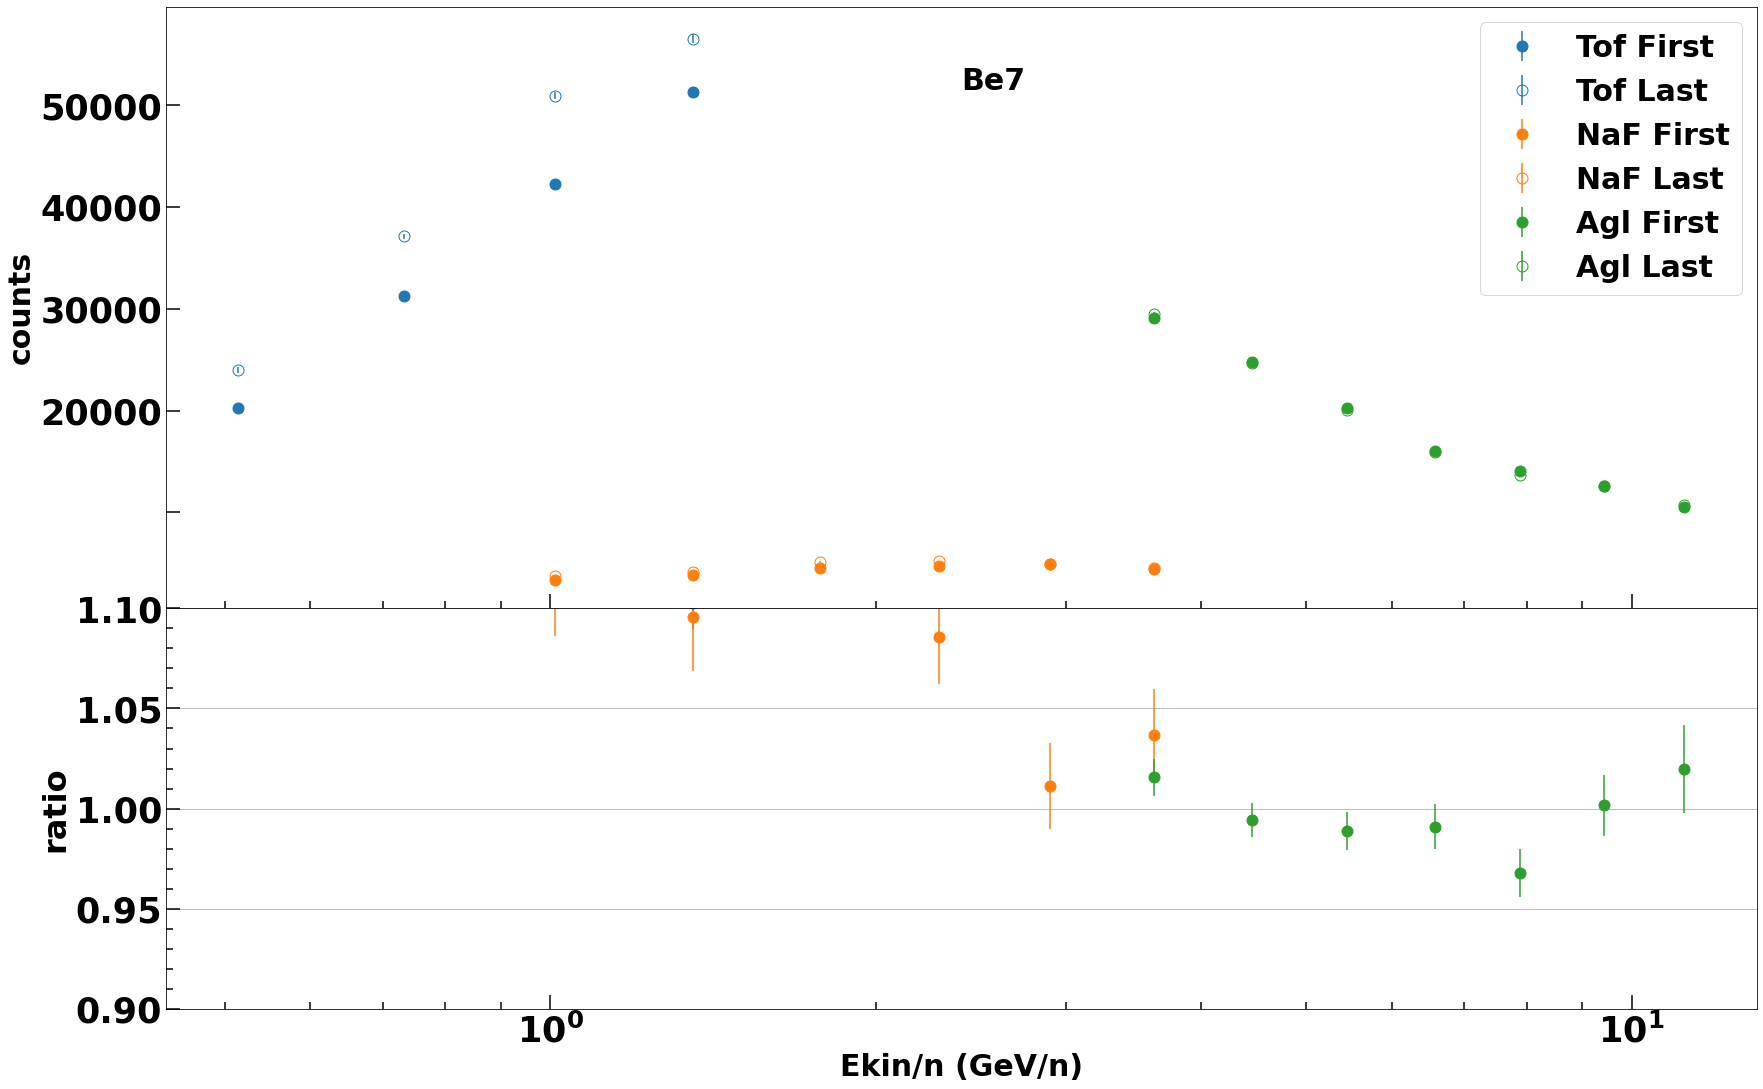

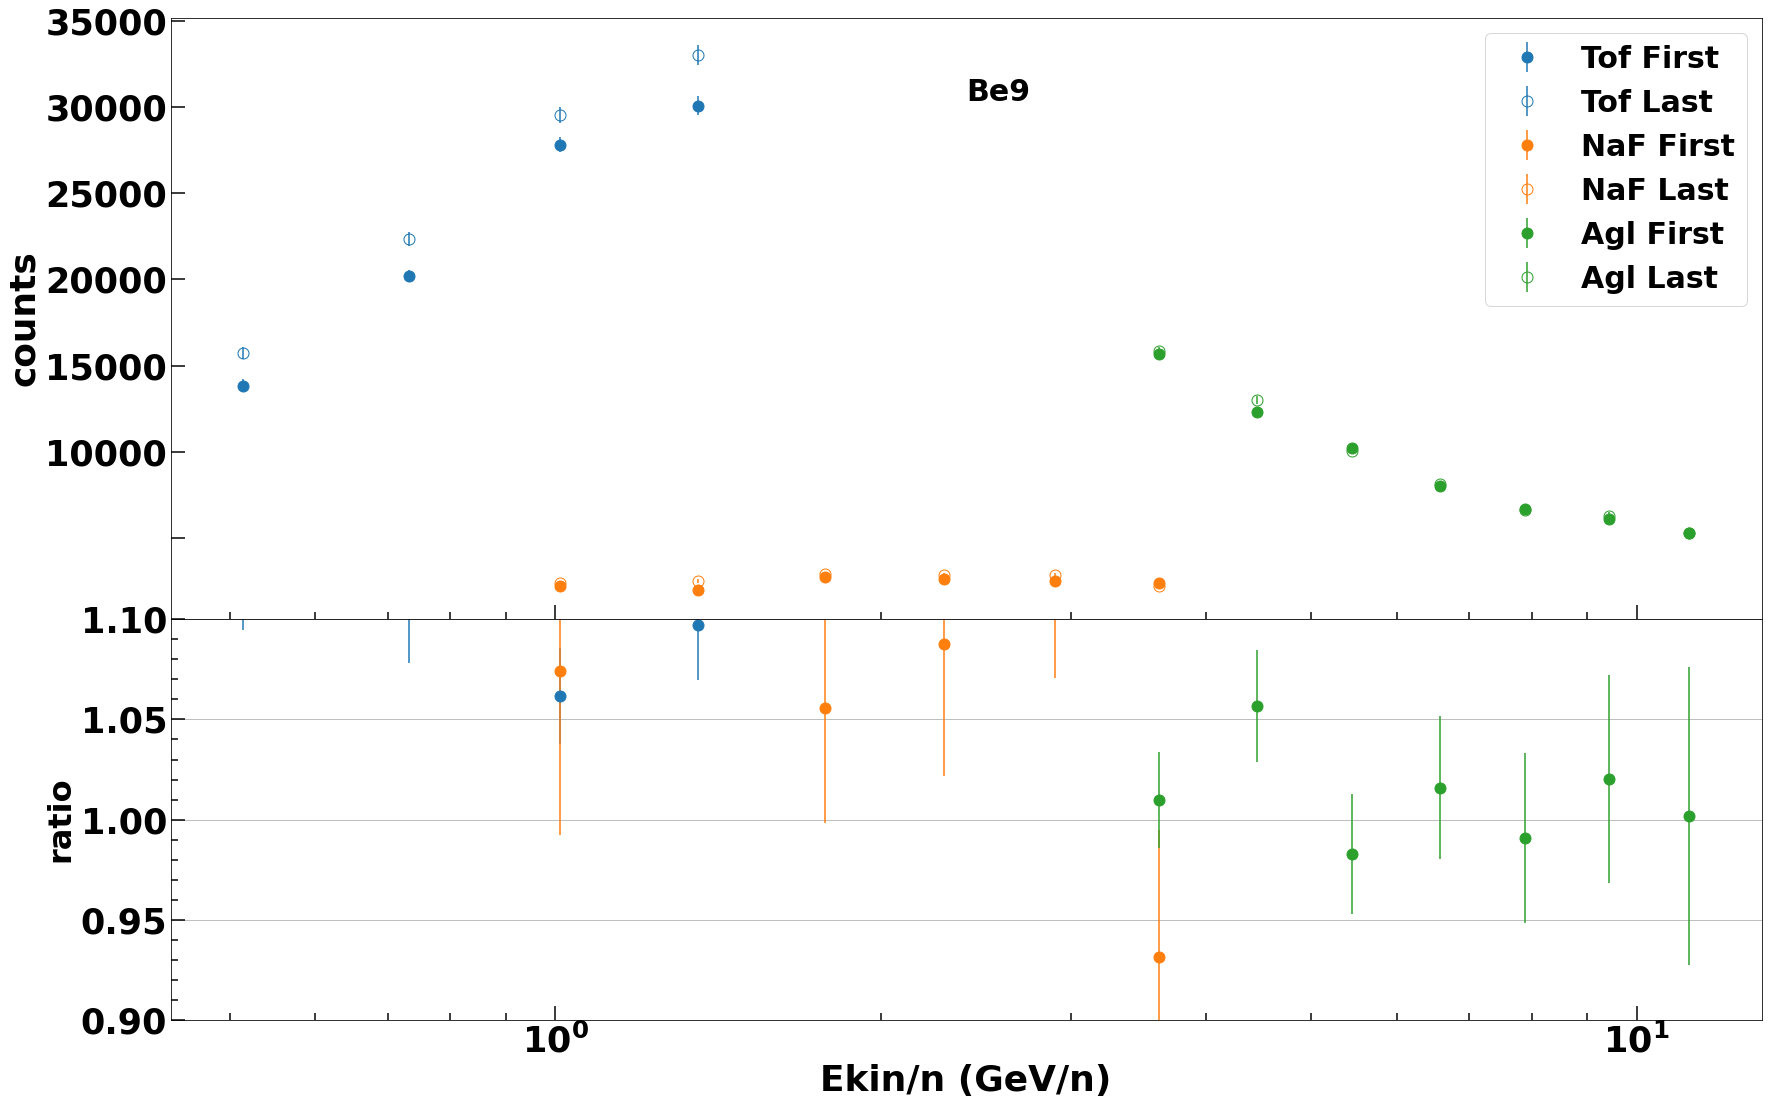

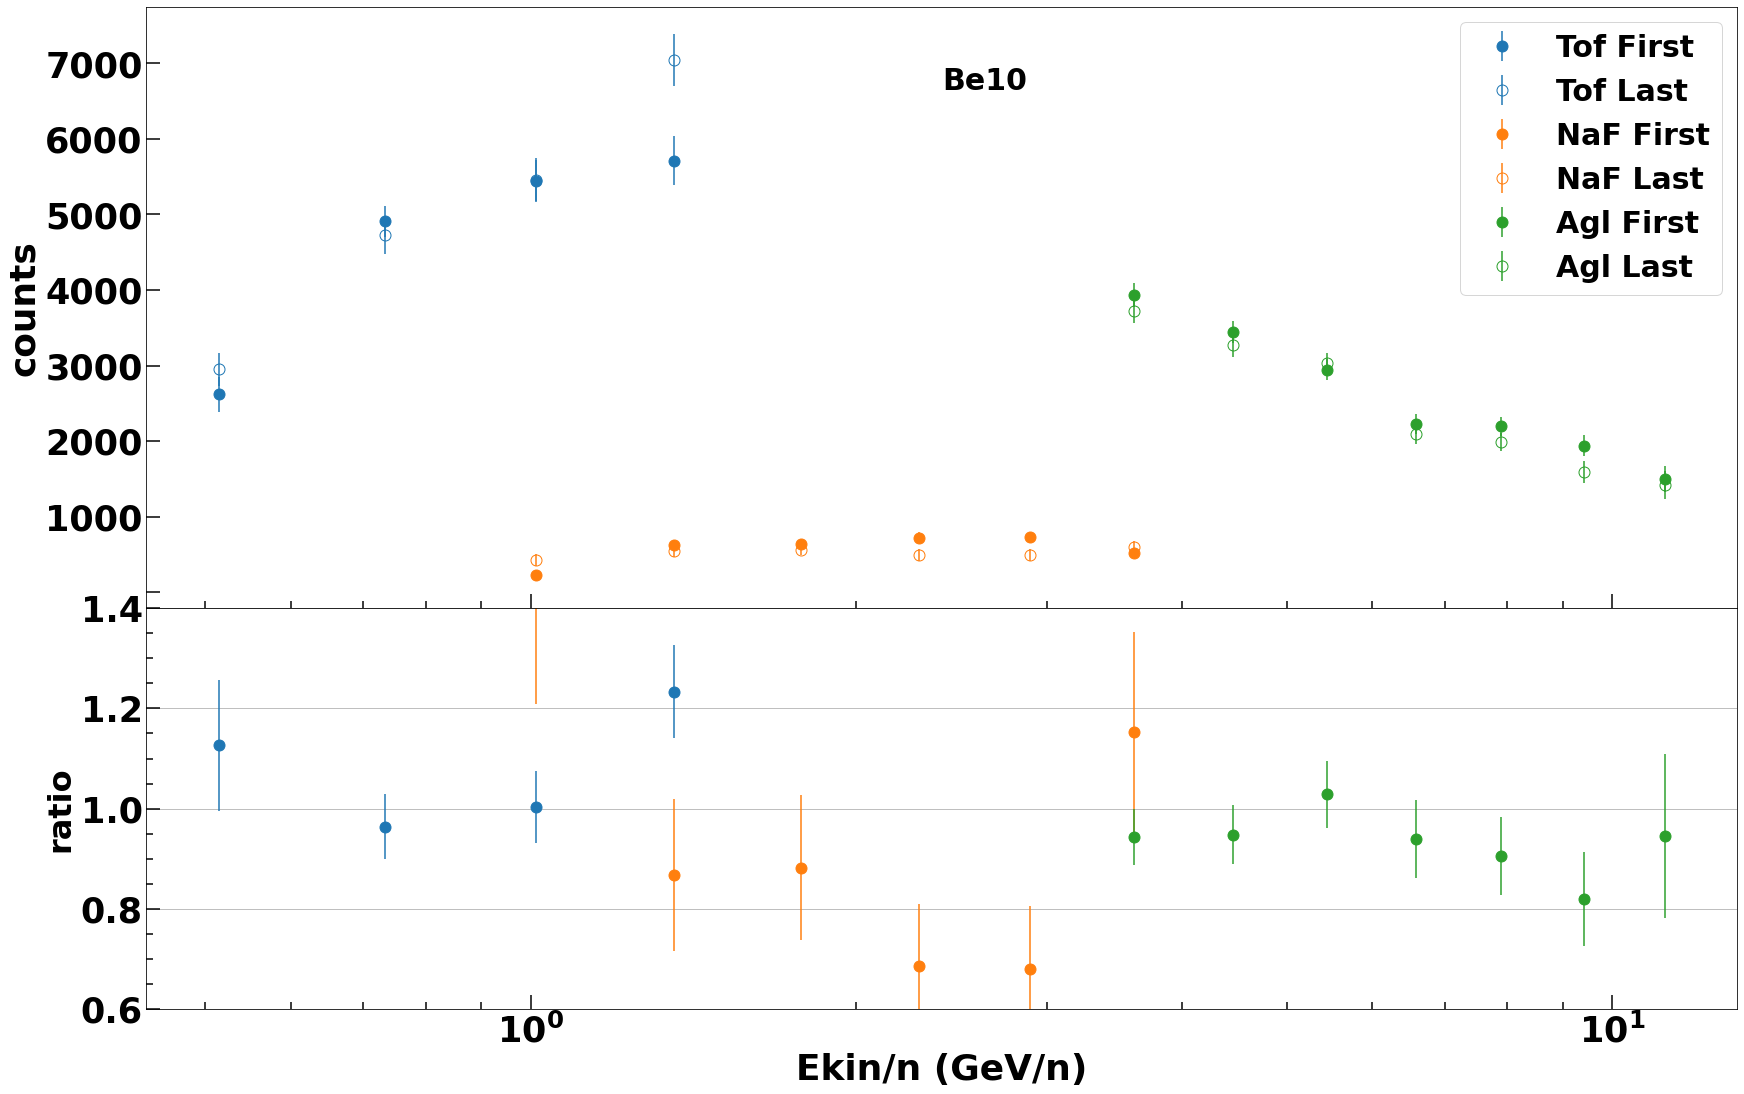

In [57]:

temp = 'Be7'
filename_compare = '/home/manbing/Documents/Data/jiahui/MC_Events/BeMC_histmass_vsekin_jiahuicommsel_test.npz'

graph_counts_jiahui = {dec: dict() for dec in detectors}                                                                                                                                                    
for dec in detectors:                                                                                                                                                                                       
    jiahui_counts_file =  pd.read_csv(f"/home/manbing/Documents/Data/jiahui/isotope_fluxes/Event_Counts_from_Fit/nevt_{detectors_alias[dec]}_10yr.txt",  sep='\s+', header=0)                               
    for iso in isotopes:                                                                                                                                                                            
        xjiahuicounts = 0.5*(jiahui_counts_file['Ek_low'] + jiahui_counts_file['Ek_high'])  
        graph_counts_jiahui[dec][iso] = MGraph(xjiahuicounts, jiahui_counts_file[f'T{temp}_N{iso}'], np.sqrt(jiahui_counts_file[f'T{temp}_N{iso}']))   
    

df_counts = np.load(f'{file_counts}')
filename_comp = '/home/manbing/Documents/lithiumanalysis/scripts/plots/plot_fitLast5yr_freeP/graph_massfit_counts.npz'
df_counts_compare = np.load(f'{filename_comp}')

figSize = (22, 15)
graph_counts_fromfit = {dec: {} for dec in detectors}
graph_counts_compare = {dec: {} for dec in detectors}
graph_counts_sum = dict()
graph_counts_sum_compare = dict()
hist_mass2d = {dec: {} for dec in detectors}
xbinning = Binning(fbinning_energy())



for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}Opt{temp}_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
        graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f"graph_counts_{dec}Opt{temp}_{iso}")
        #hist_mass2d[dec][iso] = WeightedHistogram.from_file(df_counts_compare, f"{iso}MC_{dec}_mass")
        #graph_counts_compare[dec][iso] = MGraph(xbinning.bin_centers[1:-1], np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1), np.sqrt(np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1)))
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f'{dec}_{iso}MC_counts')
        xstart = graph_counts_fromfit[dec][iso].xvalues[0]
        xend = graph_counts_fromfit[dec][iso].xvalues[-1]
        graph_counts_compare[dec][iso] = slice_graph_by_value(graph_counts_compare[dec][iso], np.array([xstart, xend]))
        
graph_ratio_be9be7_A = dict()
graph_ratio_be10be9_A = dict()
graph_ratio_be9be7_B = dict()
graph_ratio_be10be9_B = dict()        
for dec in detectors:
    graph_ratio_be9be7_A[dec] = graph_counts_fromfit[dec]['Be9']/graph_counts_fromfit[dec]['Be7']
    graph_ratio_be10be9_A[dec] = graph_counts_fromfit[dec]['Be10']/graph_counts_fromfit[dec]['Be9']
    graph_ratio_be9be7_B[dec] = graph_counts_compare[dec]['Be9']/graph_counts_compare[dec]['Be7']
    graph_ratio_be10be9_B[dec] = graph_counts_compare[dec]['Be10']/graph_counts_compare[dec]['Be9']
    
for iso in isotopes: 
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 16))                                                                                                            
    fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
    for dec in detectors:
        plot_graph(fig, ax1, graph_counts_fromfit[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} First')  
        plot_graph(fig, ax1, graph_counts_compare[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} Last', markerfacecolor="none") 
        
        graph_ratio = graph_counts_compare[dec][iso]/graph_counts_fromfit[dec][iso]
        plot_graph(fig, ax2, graph_ratio, color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}')  
        if iso == "Be7":
            graph_counts_sum[dec] = graph_counts_fromfit[dec][iso]
            graph_counts_sum_compare[dec] = graph_counts_compare[dec][iso]
        else:
            graph_counts_sum[dec] = graph_counts_sum[dec] + graph_counts_fromfit[dec][iso]
            graph_counts_sum_compare[dec] = graph_counts_sum_compare[dec] + graph_counts_compare[dec][iso]
            
    ax2.grid(axis='y')
    ax2.set_xlabel('Ekin/n (GeV/n)') 
    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])
    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts')

    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])

    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel('ratio', fontsize=32)
    if iso != "Be10":
        ax2.set_ylim([0.9, 1.1])
    else:
        ax2.set_ylim([0.6, 1.4])
    #ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax2.set_xticks(np.array([2, 4, 10]))
    ax1.text(0.5, 0.9, f'{iso}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    savefig_tofile(fig, plotdir, f"compare_counts_fromfit_T{temp}N{iso}_v23", show=True) 

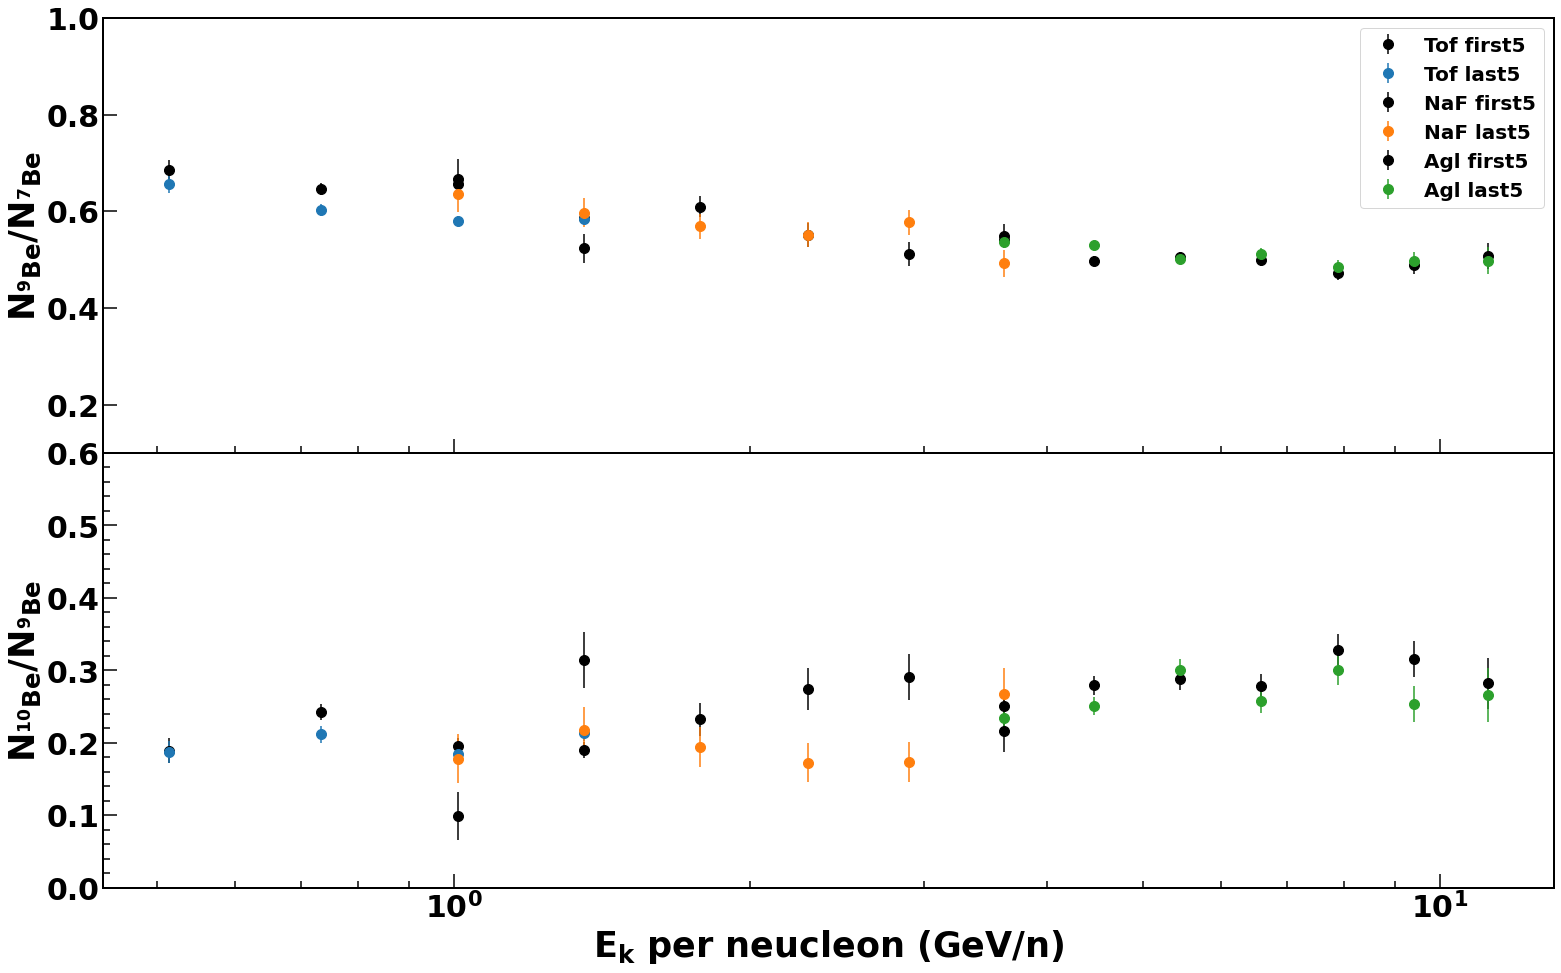

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(26, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 

for dec in detectors:
    plot_graph(fig, ax2, graph_ratio_be10be9_A[dec], color='black', style="EP", xlog=False, ylog=False, markersize=20, label='f{dec} first5')
    plot_graph(fig, ax1, graph_ratio_be9be7_A[dec], color='black', style="EP", xlog=False, ylog=False, markersize=20, label=f'{dec} first5')
    plot_graph(fig, ax2, graph_ratio_be10be9_B[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label='f{dec} last5')
    plot_graph(fig, ax1, graph_ratio_be9be7_B[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label=f'{dec} last5')
                                                                                                                             
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax2.set_ylabel(r"$\mathrm{N_{^{10}Be}/N_{^{9}Be}}$", fontsize=35)
ax1.set_ylabel(r"$\mathrm{N_{^{9}Be}/N_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
ax1.legend(fontsize=20)

ax1.set_ylim([0.1, 1.0])  
ax2.set_ylim([0.0, 0.6])
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
ax1.set_xscale('log')
ax2.set_xscale('log')
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_1309/plots_1309'
savefig_tofile(fig, plotdir, f'fit_ratio_5yr', 1)

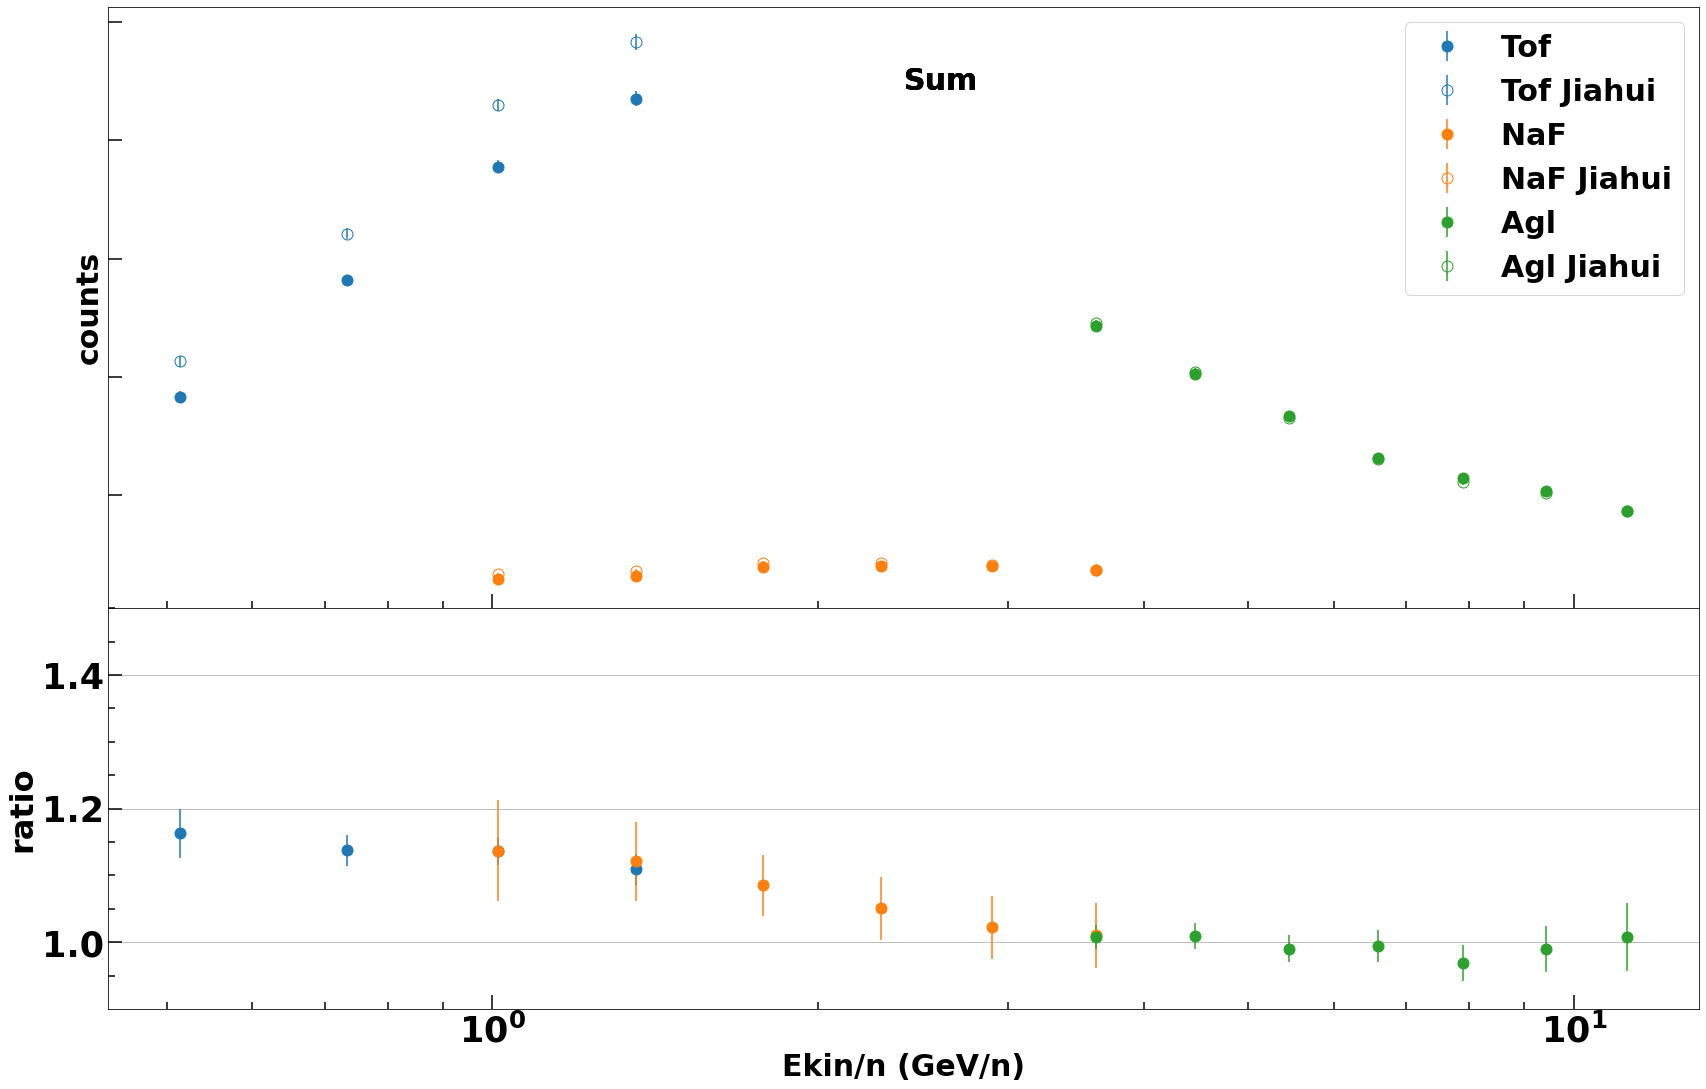

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for dec in detectors:
    plot_graph(fig, ax1, graph_counts_sum[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} ')  
    plot_graph(fig, ax1, graph_counts_sum_compare[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} Jiahui', markerfacecolor="none") 
    graph_ratio = graph_counts_sum_compare[dec]/graph_counts_sum[dec]
    plot_graph(fig, ax2, graph_ratio, color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}')  
       
    ax2.grid(axis='y')
    ax2.set_xlabel('Ekin/n (GeV/n)') 
    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])
    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts')

    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])

    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel('ratio', fontsize=32)
    ax2.set_ylim([0.9, 1.5])
    #ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax2.set_xticks(np.array([2, 4, 10]))
    ax1.text(0.5, 0.9, f'Sum', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    savefig_tofile(fig, plotdir, f"counts_sum_TBe9_rawmc", show=True) 
    


In [7]:
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file
datadir = '/home/manbing/Documents/Data/data_be_flux'
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitBeryllium_v6/flux'
variable = 'Ekin'
nuclei = 'Be'

In [8]:
with uproot.open("/home/manbing/Documents/Data/expo_time/expo_time_sf_finebin_10yr.root") as filetime:                                                                                                      
    hist_time_test = filetime[f'h_expo_rig_1_be7_bina7']                                                                                                                                                    
    yexpotime = hist_time_test.values()                           
    xvalue_time = hist_time_test.axes[0].edges() 
    graph_measuretime = MGraph(get_bin_center(xvalue_time), yexpotime, np.zeros_like(yexpotime)) 
    
#figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))
#for i, iso in enumerate(ISOTOPES[nuclei]):                                                                                                                                                                                                                                                                                                                                                                    
    
#    ax1.legend()                                                                                                                                                                                                                                                                                                                                                                       
#    ax1.set_xscale("log")   
#    ax1.set_ylabel("Exposure Time(s)")                                                                                                                                                    
    #ax1.text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
#    savefig_tofile(figure, plotdir, f"measuring_time", 1)          

/home/manbing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/manbing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


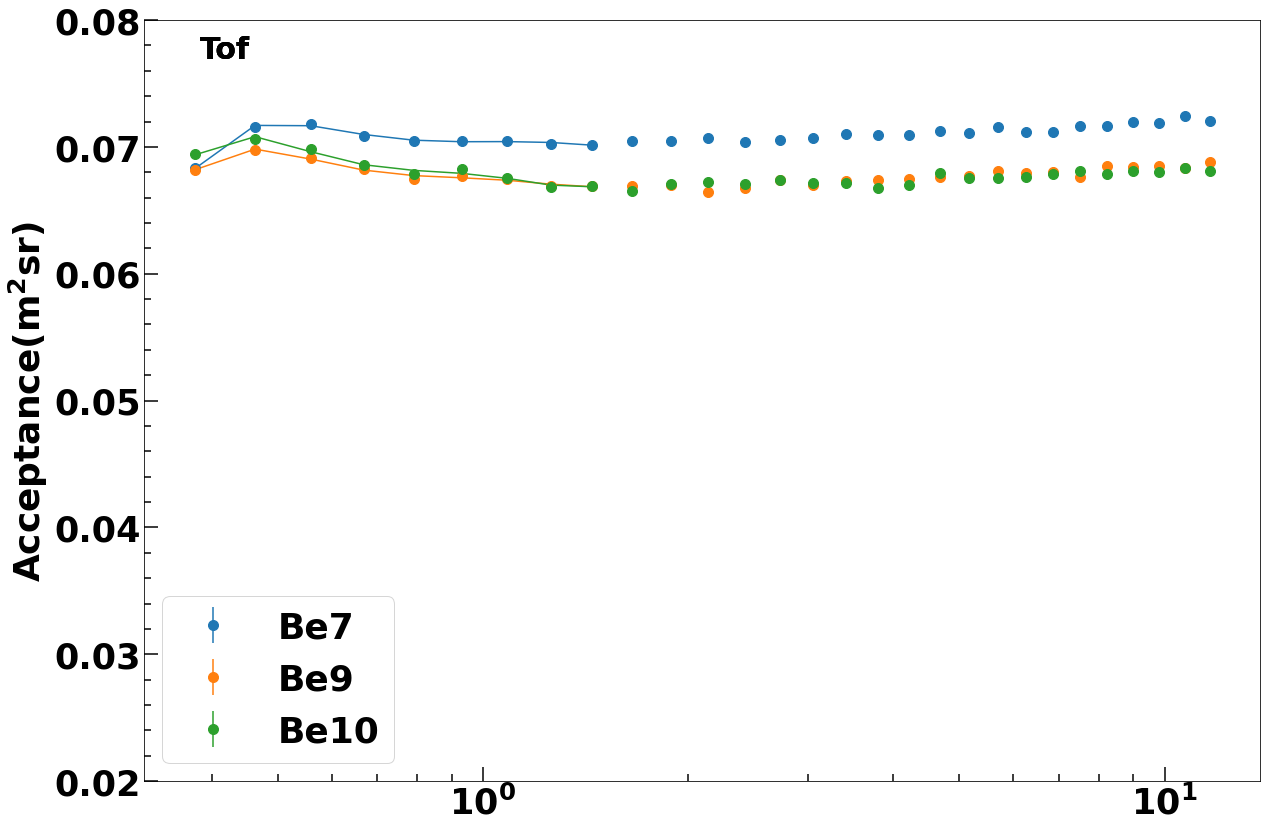

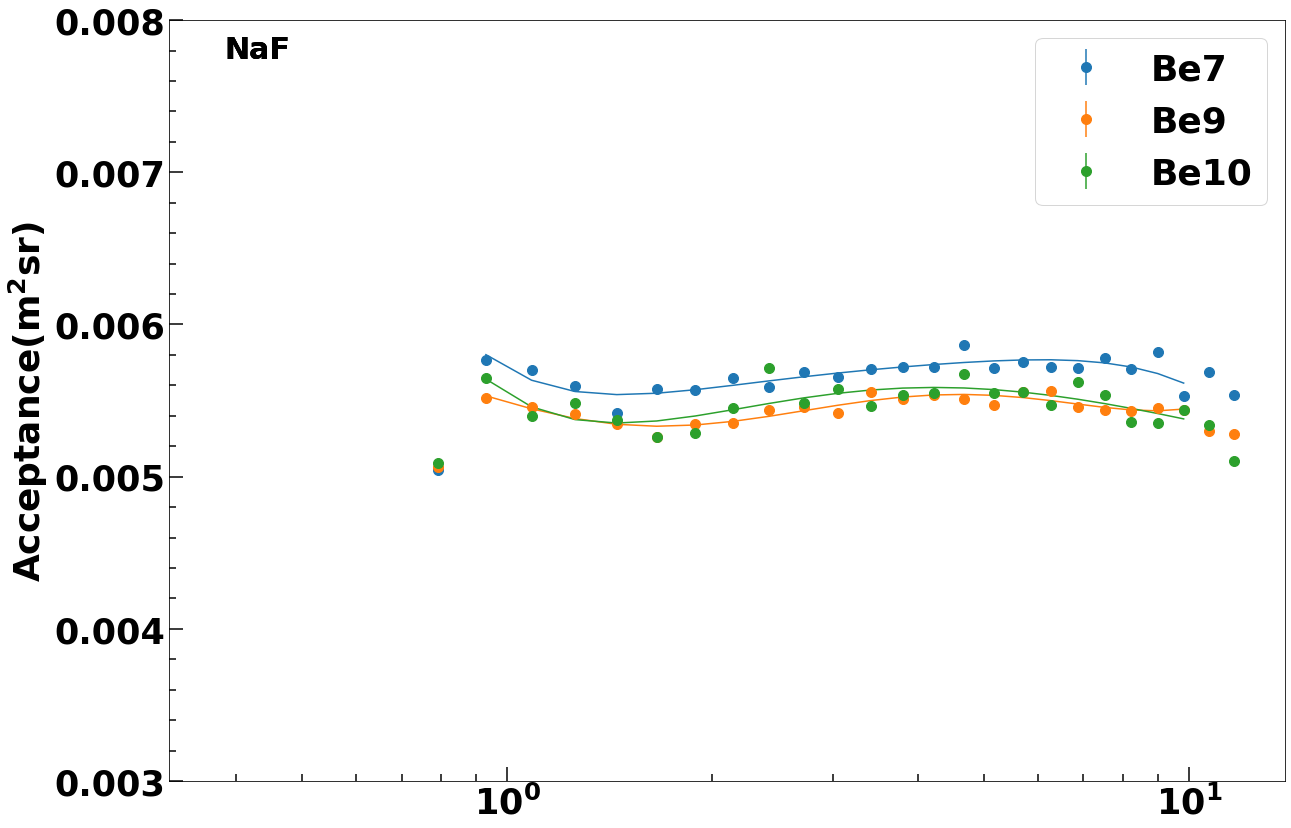

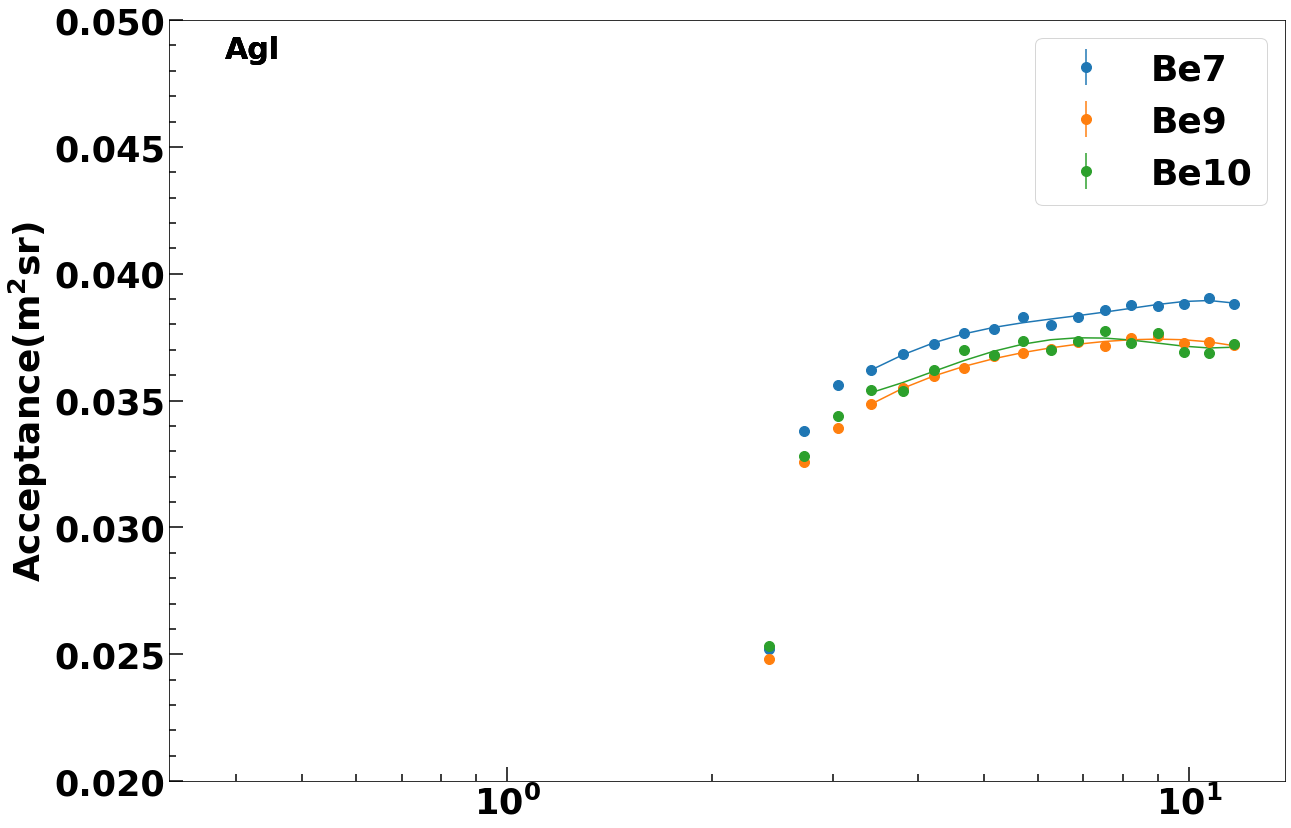

In [9]:
with np.load(os.path.join(datadir, f"BeMC_dict_graph_rawacc_{variable}.npz")) as file_acc:                                                                                                                
    graph_acc = {dec: {iso: MGraph.from_file(file_acc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES[nuclei]} for dec in detectors}                                                                              
    
ylim_range = {'Tof': [0.02, 0.08], "NaF": [0.003, 0.008], "Agl": [0.02, 0.05]}
xlim_range = {'Tof': [0.2, 1.5], 'NaF':[1.0, 10], "Agl":[3.5, 12]}
subgraph_acc =  {dec: {} for dec in detectors}
spline_subgraph_acc =  {dec: {} for dec in detectors}
graph_acc_fromspline = {dec: {} for dec in detectors}
for dec in detectors:                                                                                                                                                                                          
    figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))                                                                                                        
    for i, iso in enumerate(ISOTOPES[nuclei]): 
        subgraph_acc[dec][iso] = slice_graph_by_value(graph_acc[dec][iso], xlim_range[dec])
        x_values = subgraph_acc[dec][iso].xvalues
        spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, k=5, s=5)  
        
        ax1.plot(x_values, spline_subgraph_acc[dec][iso](np.log(x_values)))
        #acc_corr = graph_acc[dec][iso].yvalues * graph_total_effcor_ekin[dec][iso].yvalues                                                                                                                     
        #graph_corrected_acc[dec][iso] = MGraph(xbinning["Ekin"].bin_centers[1:-1], acc_corr, graph_acc[dec][iso].yerrs)                                                                                                                                                                                                                                                                                                  
        plot_graph(figure, ax1, graph_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                                            
        #plot_graph(figure, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                    
        ax1.legend()                                                                                                                                                                                                                                                                                                                                                                       
        ax1.set_xscale("log")   
        ax1.set_ylim(ylim_range[dec])
        ax1.set_ylabel(r"$\mathrm{Acceptance (m^{2} sr)}$")                                                                                                                                                    
        ax1.text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
    savefig_tofile(figure, plotdir, f"acc_{nuclei}_{dec}_{variable}", 1)                                                                                          
    

################################################################################################ <br>
####compute the raw flux with counts from the fit <font color="red">all paremeters free</font>  
#################################################################################################


xvalues			yvalues			yerrs
0.4631			0.21445025367749107			0.0029183988562532376
0.5589999999999999			0.2025460506323133			0.0018489725713567624
0.66835			0.18968471795695008			0.0015123632091637968
0.79125			0.17043202417289716			0.0012400856308326178
0.9302999999999999			0.15072353684657824			0.0009632668304918548
1.08555			0.1292288753380571			0.0010869253312749446


xvalues			yvalues			yerrs
0.4631			0.14379889374497298			0.0042490991103348195
0.5589999999999999			0.1396400375604381			0.00323546199596822
0.66835			0.12273519594447073			0.0025663295177723523
0.79125			0.11128660118439603			0.0020596119094313963
0.9302999999999999			0.09286270127559862			0.0016454813399509381
1.08555			0.08293694613380131			0.0015216200967651848


xvalues			yvalues			yerrs
0.4631			0.025628455299530273			0.0025453770605409227
0.5589999999999999			0.026927248666820718			0.0020361570891052313
0.66835			0.028256917734858732			0.0016024778733408297
0.79125			0.026038466928681933			0.0012784114216222967
0.

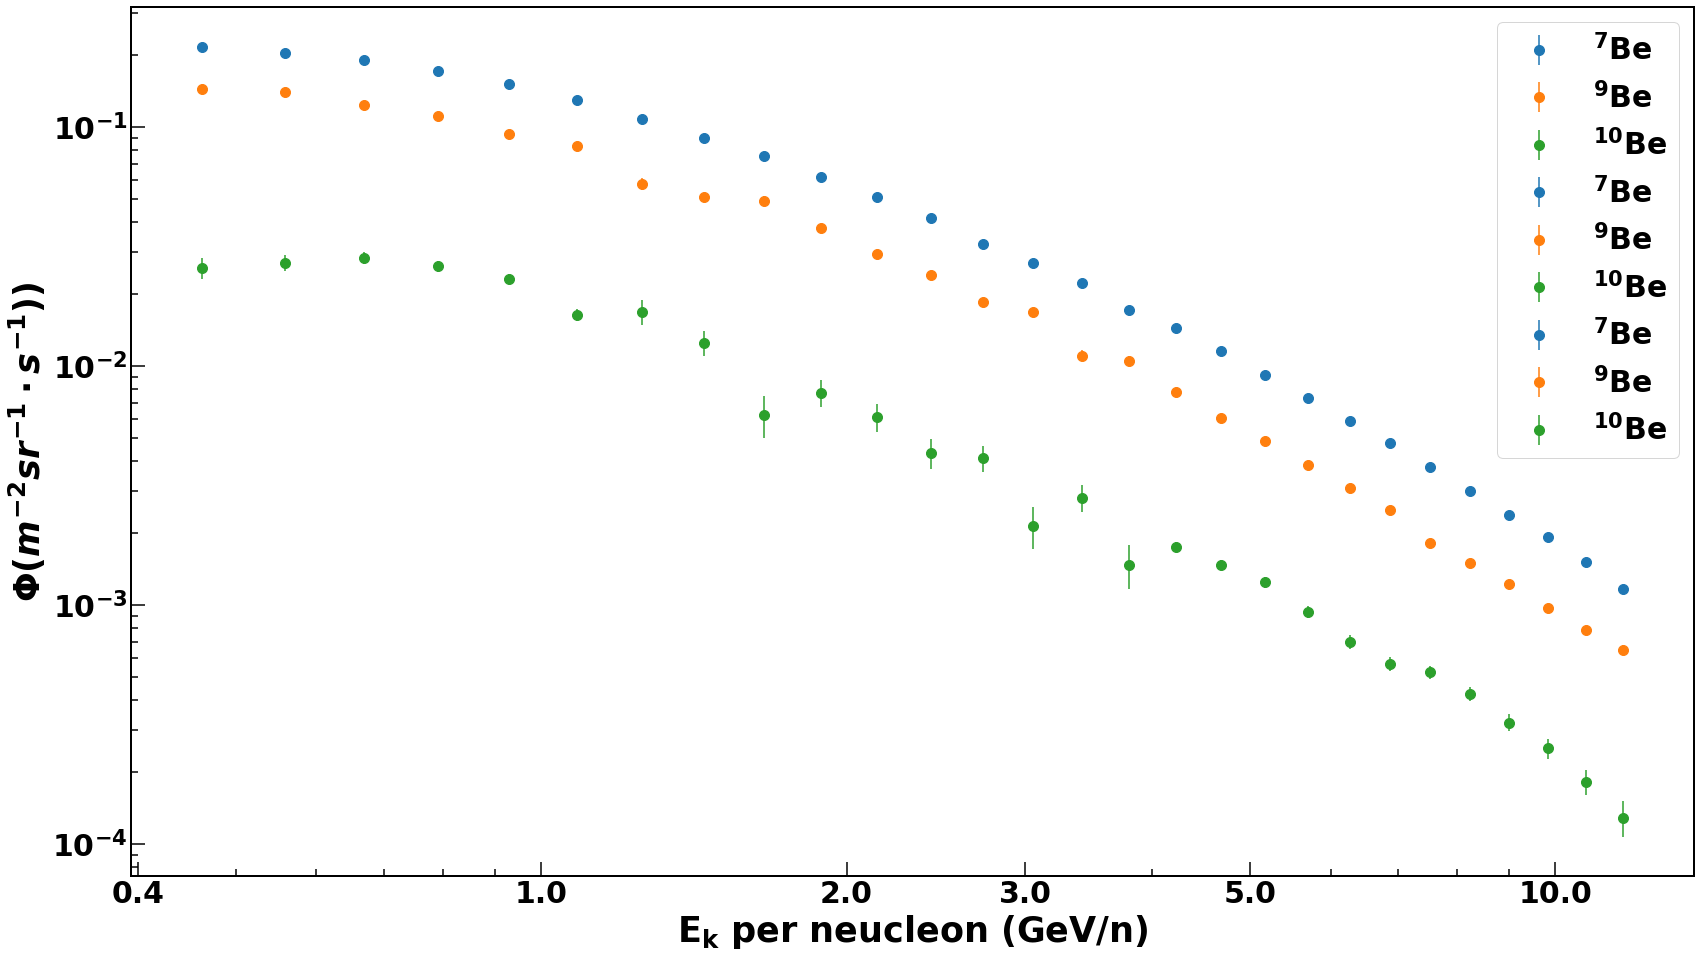

In [11]:
graph_flux_raw = {dec: dict() for dec in detectors}   
xbinning = {"Rigidity": Binning(fbinning_energy()), "Ekin":Binning(fbinning_energy())}   
df_flux = dict() 
for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:                                                                                                                                                                               
        xenergy = graph_counts_fromfit[dec][iso].xvalues                                                                                                                                                               
        counts = graph_counts_fromfit[dec][iso].yvalues                                                                                                                                                                
        counts_err = graph_counts_fromfit[dec][iso].yerrs                                                                                                                                                              
        #effcor = slice_graph_by_value(graph_total_effcor_ekin[dec][iso], [xenergy[0], xenergy[-1]])                                                                                                            
        acc = spline_subgraph_acc[dec][iso](np.log(xenergy))  
        graph_acc_forerr = slice_graph_by_value(graph_acc[dec][iso], [xenergy[0], xenergy[-1]])  
        acc_err = graph_acc_forerr.yerrs
        time = slice_graph_by_value(graph_measuretime, [xenergy[0], xenergy[-1]])                                                                                                                              
        indices = xbinning['Ekin'].get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
        #bin_widths = xbinning[variable].bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
        bin_edges = xbinning['Ekin'].edges[indices[0]: indices[1]+2]                                                                                                                                         
        bin_widths = bin_edges[1:] - bin_edges[:-1]                                                                                                                                                            
        #assert (np.all(xenergy == effcor.xvalues))                                                                                                                                                                                                                                                                                                                             
        assert (np.all(xenergy == time.xvalues))                                                                                                                                                               
        assert (np.all(xenergy == get_bin_center(bin_edges)))                                                                                                                                                  
        flux_raw = counts /(acc *time.yvalues * bin_widths)                                                                                                                               
        flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
        graph_flux_raw[dec][iso] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
        print(graph_flux_raw[dec][iso])
        
fig, ax1 = plt.subplots(figsize=(28, 16))
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        plot_graph(fig, ax1, graph_flux_raw[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        graph_flux_raw[dec][iso].add_to_file(df_flux, f'graph_rawflux_{dec}{iso}')
        
ax1.set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux', 1)
np.savez(os.path.join('/home/manbing/Documents/lithiumanalysis/scripts/plots/unfold', 'df_rawisoflux_vsEkin.npz'), **df_flux)


[ 0.51105   0.7298    1.007925  1.352275  1.7719    2.281325  2.88855
  3.606925  4.450025  5.43725   6.569625  7.875175  9.41065  11.175925]


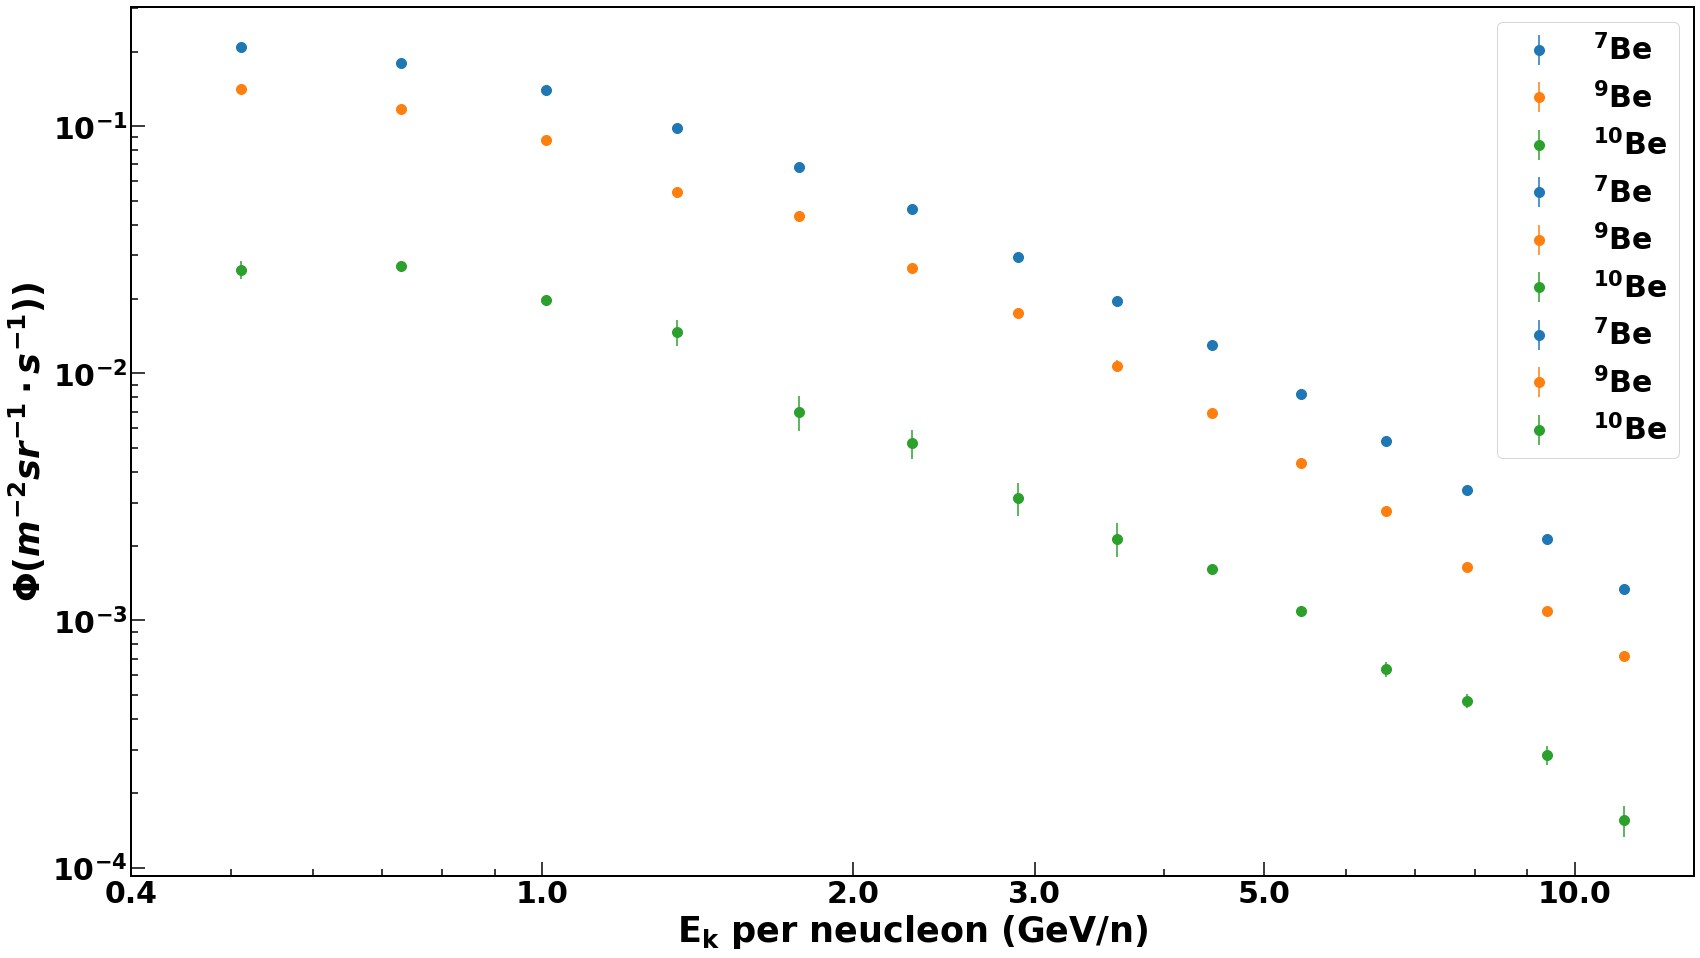

In [19]:
from tools.binnings_collection import fbinning_energy_rebin
graph_flux_raw_rebin = {dec: dict() for dec in detectors} 
graph_flux_raw_rebin_combine = dict()
xbinning_rebin = Binning(fbinning_energy_rebin())


for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:  
        npoint = int(len(graph_flux_raw[dec][iso].xvalues)/2)
        flux_rebin = np.zeros(npoint)
        flux_rebin_err = np.zeros(npoint)
        x_values = np.zeros(npoint)
        for i in range(npoint):
            x_values[i] = (graph_flux_raw[dec][iso].xvalues[2*i] + graph_flux_raw[dec][iso].xvalues[2*i+1])/2
            flux_rebin[i] = (graph_flux_raw[dec][iso].yvalues[2*i] + graph_flux_raw[dec][iso].yvalues[2*i+1])/2
            flux_rebin_err[i] = (graph_flux_raw[dec][iso].yerrs[2*i] + graph_flux_raw[dec][iso].yerrs[2*i+1])/2
         
        graph_flux_raw_rebin[dec][iso] = MGraph(x_values, flux_rebin, flux_rebin_err)
        
fig, ax1 = plt.subplots(figsize=(28, 16))
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        plot_graph(fig, ax1, graph_flux_raw_rebin[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        
ax1.set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux_rebin', 1)

for iso in ISOTOPES[nuclei]:
    graph_flux_raw_rebin_combine[iso] = graph_flux_raw_rebin['Tof'][iso]
    graph_flux_raw_rebin_combine[iso] = concatenate_graphs(graph_flux_raw_rebin_combine[iso], graph_flux_raw_rebin['NaF'][iso])
    graph_flux_raw_rebin_combine[iso] = concatenate_graphs(graph_flux_raw_rebin_combine[iso], graph_flux_raw_rebin['Agl'][iso])
    
    
graph_flux_ratio_10to9 = graph_flux_raw_rebin_combine['Be10']/graph_flux_raw_rebin_combine['Be9']
graph_flux_ratio_9to7 = graph_flux_raw_rebin_combine['Be9']/graph_flux_raw_rebin_combine['Be7']
x_values = graph_flux_ratio_10to9.xvalues
print(x_values)
indices = xbinning_rebin.get_indices([x_values[0], x_values[-1]])
x_bin_edges = xbinning_rebin.edges[indices[0]: indices[1]+2] 

# Stack the arrays horizontally to create a 2D array
combined_array_be10tobe9 = np.vstack((x_bin_edges[:-1], x_bin_edges[1:], graph_flux_ratio_10to9.yvalues, graph_flux_ratio_10to9.yerrs)).T
combined_array_be9tobe7 = np.vstack((x_bin_edges[:-1], x_bin_edges[1:], graph_flux_ratio_9to7.yvalues, graph_flux_ratio_9to7.yerrs)).T
# Save the combined array to the text file

filepath = '/home/manbing/Documents/Data/data_be_flux/results'
np.savetxt(os.path.join(filepath, 'Be10ToBe9.txt'), combined_array_be10tobe9, fmt='%f', delimiter='\t')
np.savetxt(os.path.join(filepath, 'Be9ToBe7.txt'), combined_array_be9tobe7, fmt='%f', delimiter='\t')



####plot flux ratio


xvalues			yvalues			yerrs
0.51105			0.18542161348231015			0.01688939513500797
0.7298			0.23200994663604904			0.01313687940782639
1.007925			0.22466706352147514			0.011779523372028287
1.352275			0.2700784331691065			0.03514239888819599
1.7719			0.16078995280427621			0.026732515880222452
2.281325			0.19561584060923762			0.028338749367901896
2.88855			0.1773562179220242			0.027956060815838617
3.6069250000000004			0.19914150767327873			0.032601170229892895
4.450025			0.23359431579847148			0.012405188700219413
5.437250000000001			0.25040716461770196			0.014187357600761655
6.569625			0.22802304912391996			0.016425099215879202
7.875175			0.28604494406581676			0.021067431937297376
9.41065			0.26133494823856995			0.024824475059161685
11.175925			0.21720673218532255			0.032466311996211486


xvalues			yvalues			yerrs
0.733			0.2153			0.0173
1.013			0.1723			0.0138
1.3599999999999999			0.2059			0.0199
1.7799999999999998			0.135			0.0161
2.29			0.1692			0.0178
2.9			0.1862			0.0208
3.615			0.2041	

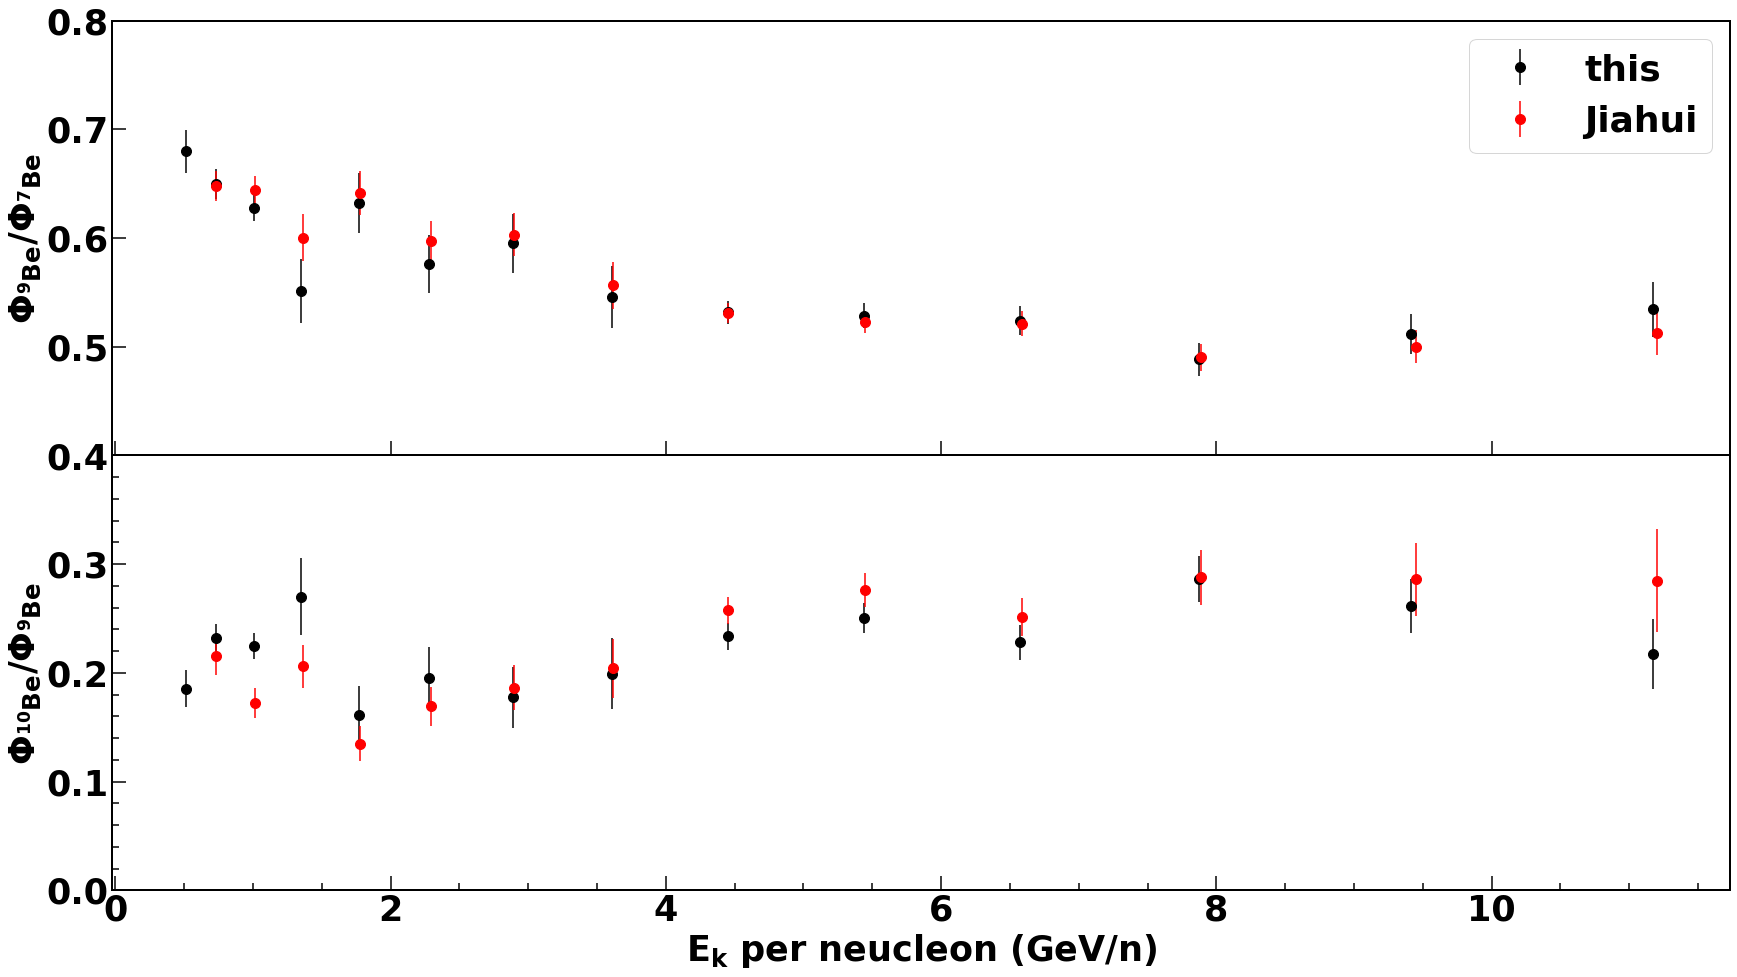

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(29, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 
ax2.set_ylabel(r"$\mathrm{\Phi_{^{10}Be}/\Phi_{^{9}Be}}$", fontsize=35) 
plot_graph(fig, ax2, graph_flux_ratio_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax2.set_ylim([0.0, 0.58])                                                                                                                             

#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
 
ax1.set_ylabel(r"$\mathrm{\Phi_{^{9}Be}/\Phi_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
plot_graph(fig, ax1, graph_flux_ratio_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20, label='this')
ax1.set_ylim([0.1, 1.0])                                                                                                                              
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 


file_path = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be10Be9.txt'
file_path2 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be9Be7.txt'
# Load the data from the text file
data = np.loadtxt(file_path)
data2 = np.loadtxt(file_path2)
# Split the data into separate arrays for each column
column1 = data[:, 0]
column2 = data[:, 1]
column3 = data[:, 2]
column4 = data[:, 3]
xv = (column1 + column2)/2

column11 = data2[:, 0]
column22 = data2[:, 1]
column33 = data2[:, 2]
column44 = data2[:, 3]
xv2 = (column11 + column22)/2
ax1.set_ylim(0.4, 0.8)
ax2.set_ylim([0.0, 0.4])
graph_laurent_ratiobe10 = MGraph(xv, column3, column4)
graph_laurent_ratiobe9 = MGraph(xv, column33, column44)

#plot_graph(fig, ax2, graph_laurent_ratiobe10, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Laurent')
plot_graph(fig, ax1, graph_laurent_ratiobe9, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Jiahui')
# Print the arrays
ax1.legend()
print(graph_flux_ratio_10to9)
print(graph_laurent_ratiobe10)
file_jh_be10 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be10Be9.txt'
file_jh_be9 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be9Be7.txt'
df_jhbe10 = np.loadtxt(file_jh_be10)
df_jhbe9 = np.loadtxt(file_jh_be9)
c1_jh = df_jhbe10[:, 0]
c2_jh = df_jhbe10[:, 1]
c3_jh = df_jhbe10[:, 2]
c4_jh = df_jhbe10[:, 3]
xv_jh = (c1_jh + c2_jh)/2
graph_jiahui_ratiobe10 = MGraph(xv_jh, c3_jh, c4_jh)
plot_graph(fig, ax2, graph_jiahui_ratiobe10, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Jiahui')
savefig_tofile(fig, filepath, 'be_fluxratio', 1)

################################################################################################ <br>
####compute the raw flux with counts from the fit <font color="red">fix shape parameters, only mean is free</font>  
#################################################################################################


xvalues			yvalues			yerrs
0.4631			0.21455142014864834			0.0029369694100695627
0.5589999999999999			0.20293706542549517			0.0018325651806506205
0.66835			0.18960566595776104			0.001432837063450004
0.79125			0.16977519256207696			0.0011727093825454876
0.9302999999999999			0.14966985609677202			0.0009123477947038775
1.08555			0.12795546945339495			0.000984941391180456


xvalues			yvalues			yerrs
0.4631			0.14484333699046256			0.004228742129637934
0.5589999999999999			0.13796304422627767			0.003029254216430245
0.66835			0.12198926885520443			0.002384198835007471
0.79125			0.11239975744139385			0.001918965821381417
0.9302999999999999			0.09534340589863215			0.0015387154491024171
1.08555			0.0860803505568624			0.0013387442070427833


xvalues			yvalues			yerrs
0.4631			0.02449602220619647			0.0025282484777777972
0.5589999999999999			0.02818771510505827			0.0018749680449963054
0.66835			0.02908005303061118			0.0014804692280820913
0.79125			0.025611789837821114			0.00118627182020319
0.9302999

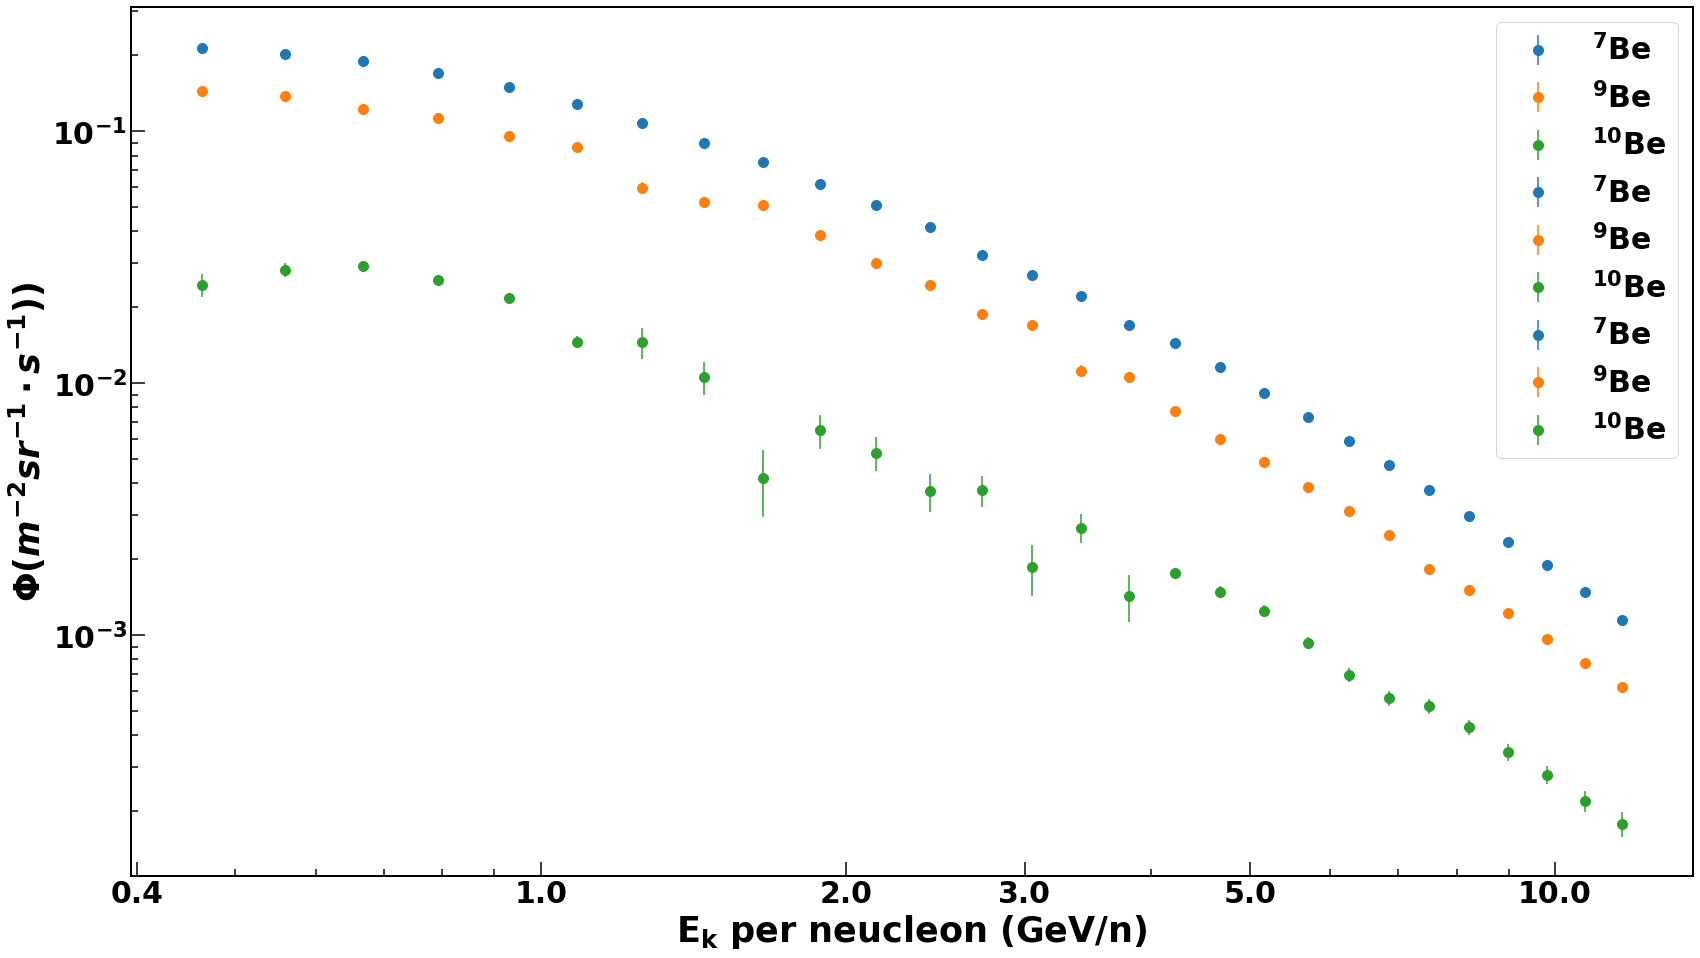

In [12]:
graph_flux_raw_fixshape = {dec: dict() for dec in detectors}   
xbinning = {"Rigidity": Binning(fbinning_energy()), "Ekin":Binning(fbinning_energy())}   
for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:                                                                                                                                                                               
        xenergy = graph_counts_fromfit_fix[dec][iso].xvalues                                                                                                                                                               
        counts = graph_counts_fromfit_fix[dec][iso].yvalues                                                                                                                                                                
        counts_err = graph_counts_fromfit_fix[dec][iso].yerrs                                                                                                                                                              
        #effcor = slice_graph_by_value(graph_total_effcor_ekin[dec][iso], [xenergy[0], xenergy[-1]])                                                                                                            
        acc = spline_subgraph_acc[dec][iso](np.log(xenergy))  
        graph_acc_forerr = slice_graph_by_value(graph_acc[dec][iso], [xenergy[0], xenergy[-1]])  
        acc_err = graph_acc_forerr.yerrs
        time = slice_graph_by_value(graph_measuretime, [xenergy[0], xenergy[-1]])                                                                                                                              
        indices = xbinning['Ekin'].get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
        #bin_widths = xbinning[variable].bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
        bin_edges = xbinning['Ekin'].edges[indices[0]: indices[1]+2]                                                                                                                                         
        bin_widths = bin_edges[1:] - bin_edges[:-1]                                                                                                                                                            
        #assert (np.all(xenergy == effcor.xvalues))                                                                                                                                                                                                                                                                                                                             
        assert (np.all(xenergy == time.xvalues))                                                                                                                                                               
        assert (np.all(xenergy == get_bin_center(bin_edges)))                                                                                                                                                  
        flux_raw = counts /(acc *time.yvalues * bin_widths)                                                                                                                               
        flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
        graph_flux_raw_fixshape[dec][iso] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
        print(graph_flux_raw_fixshape[dec][iso])
        
fig, ax1 = plt.subplots(figsize=(28, 16))
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        plot_graph(fig, ax1, graph_flux_raw_fixshape[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        
ax1.set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux_fixshape', 1)



In [21]:
from tools.binnings_collection import fbinning_energy_rebin
graph_flux_raw_fixshape_rebin = {dec: dict() for dec in detectors} 
graph_flux_raw_fixshape_rebin_combine = dict()
xbinning_rebin = Binning(fbinning_energy_rebin())


for dec in detectors:                                                                                                                                                                                          
    for iso in ISOTOPES[nuclei]:  
        npoint = int(len(graph_flux_raw_fixshape[dec][iso].xvalues)/2)
        flux_rebin = np.zeros(npoint)
        flux_rebin_err = np.zeros(npoint)
        x_values = np.zeros(npoint)
        for i in range(npoint):
            x_values[i] = (graph_flux_raw_fixshape[dec][iso].xvalues[2*i] + graph_flux_raw_fixshape[dec][iso].xvalues[2*i+1])/2
            flux_rebin[i] = (graph_flux_raw_fixshape[dec][iso].yvalues[2*i] + graph_flux_raw_fixshape[dec][iso].yvalues[2*i+1])/2
            flux_rebin_err[i] = (graph_flux_raw_fixshape[dec][iso].yerrs[2*i] + graph_flux_raw_fixshape[dec][iso].yerrs[2*i+1])/2
         
        graph_flux_raw_fixshape_rebin[dec][iso] = MGraph(x_values, flux_rebin, flux_rebin_err)
        
fig, ax1 = plt.subplots(figsize=(28, 16))
for dec in detectors:
    for iso in ISOTOPES[nuclei]:
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_flux_raw_fixshape_rebin[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
        else:
            plot_graph(fig, ax1, graph_flux_raw_fixshape_rebin[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20)
ax1.set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux_rebin', 1)

for iso in ISOTOPES[nuclei]:
    graph_flux_raw_fixshape_rebin_combine[iso] = graph_flux_raw_fixshape_rebin['Tof'][iso]
    graph_flux_raw_fixshape_rebin_combine[iso] = concatenate_graphs(graph_flux_raw_fixshape_rebin_combine[iso], graph_flux_raw_fixshape_rebin['NaF'][iso])
    graph_flux_raw_fixshape_rebin_combine[iso] = concatenate_graphs(graph_flux_raw_fixshape_rebin_combine[iso], graph_flux_raw_fixshape_rebin['Agl'][iso])
    
    
graph_fluxratio_fixshape_10to9 = graph_flux_raw_fixshape_rebin_combine['Be10']/graph_flux_raw_fixshape_rebin_combine['Be9']
graph_fluxratio_fixshape_9to7 = graph_flux_raw_fixshape_rebin_combine['Be9']/graph_flux_raw_fixshape_rebin_combine['Be7']
x_values = graph_fluxratio_fixshape_10to9.xvalues
print(x_values)
indices = xbinning_rebin.get_indices([x_values[0], x_values[-1]])
x_bin_edges = xbinning_rebin.edges[indices[0]: indices[1]+2] 
ax1.set_ylim([0.0001, 1.0])
ax1.text(0.05, 0.98, f"Raw flux, without unfolding", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                                                                                                                                                                                           
# Stack the arrays horizontally to create a 2D array
filepath = '/home/manbing/Documents/Data/data_be_flux/results'

print(graph_fluxratio_fixshape_10to9)
print(graph_fluxratio_fixshape_9to7)
graph_fluxratio_fixshape_10to9.yvalues[0:4] = [0.16998944, 0.21164759, 0.18467183, 0.21122314]
graph_fluxratio_fixshape_9to7.yvalues[0:4] = [0.67495194, 0.66353918, 0.66423174, 0.57525368]
print(graph_fluxratio_fixshape_10to9)
combined_array_be10tobe9_fixshape = np.vstack((x_bin_edges[:-1], x_bin_edges[1:], graph_fluxratio_fixshape_10to9.yvalues, graph_fluxratio_fixshape_10to9.yerrs)).T
combined_array_be9tobe7_fixshape = np.vstack((x_bin_edges[:-1], x_bin_edges[1:], graph_fluxratio_fixshape_9to7.yvalues, graph_fluxratio_fixshape_9to7.yerrs)).T
np.savetxt(os.path.join(filepath, 'Be10ToBe9_fixshape.txt'), combined_array_be10tobe9_fixshape, fmt='%f', delimiter='\t')
np.savetxt(os.path.join(filepath, 'Be9ToBe7_fixshape.txt'), combined_array_be9tobe7_fixshape, fmt='%f', delimiter='\t')

NameError: name 'graph_flux_raw_fixshape' is not defined

NameError: name 'graph_fluxratio_fixshape_10to9' is not defined

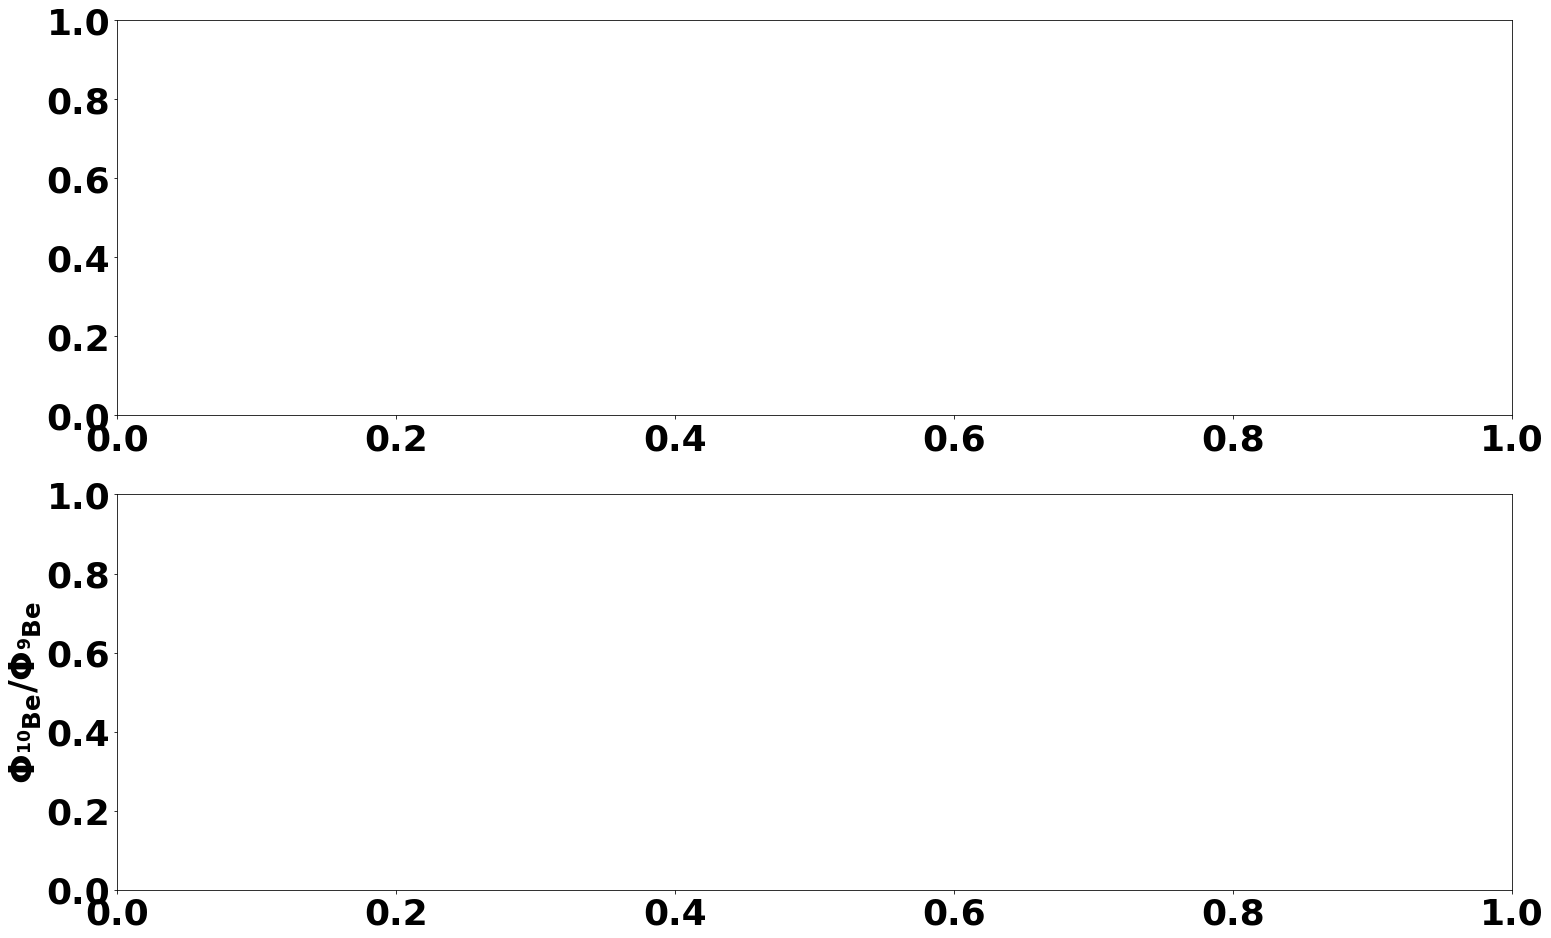

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(25, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 
ax2.set_ylabel(r"$\mathrm{\Phi_{^{10}Be}/\Phi_{^{9}Be}}$", fontsize=35) 
plot_graph(fig, ax2, graph_fluxratio_fixshape_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
#plot_graph(fig, ax2, graph_fluxratio_fixshape_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax2.set_ylim([0.0, 0.58])                                                                                                                             

#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
 
ax1.set_ylabel(r"$\mathrm{\Phi_{^{9}Be}/\Phi_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
plot_graph(fig, ax1, graph_fluxratio_fixshape_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20, label='this-fix shape')
ax1.set_ylim([0.1, 1.0])                                                                                                                              
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
#plot_graph(fig, ax2, graph_flux_ratio_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
#plot_graph(fig, ax1, graph_flux_ratio_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20, label='this')


#file_path = "/home/manbing/Documents/lithiumanalysis/Plots_SPS_manbing/Jiahui_ICRC2023_results/ratio_Be10Be9.txt"
#file_path2 = "/home/manbing/Documents/lithiumanalysis/Plots_SPS_manbing/Jiahui_ICRC2023_results/ratio_Be9Be7.txt"
file_path7 = "/home/manbing/Documents/Data/jiahui/laurent/fluxes/7Be_21_Be7.txt"
file_path9 = "/home/manbing/Documents/Data/jiahui/laurent/fluxes/9Be_21_Be9.txt"
file_path10 = "/home/manbing/Documents/Data/jiahui/laurent/fluxes/10Be_21_Be10.txt"
# Load the data from the text file
data = np.loadtxt(file_path7)
data2 = np.loadtxt(file_path9)
data3 = np.loadtxt(file_path10)
# Split the data into separate arrays for each column
column71 = data[:, 0]
column72 = data[:, 1]
column73 = data[:, 2]
column74 = data[:, 3]
xv = (column71 + column72)/2

column93 = data2[:, 2]
column94 = data2[:, 3]
column03 = data3[:, 2]
column04 = data3[:, 3]

graph_laurent_fluxbe7 = MGraph(xv, column73, column74)
graph_laurent_fluxbe9 = MGraph(xv, column93, column94)
graph_laurent_fluxbe10 = MGraph(xv, column03, column04)
graph_laurent_ratiobe9 = graph_laurent_fluxbe9/graph_laurent_fluxbe7
graph_laurent_ratiobe10 = graph_laurent_fluxbe10/graph_laurent_fluxbe9

plot_graph(fig, ax2, graph_laurent_ratiobe10, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Laurent')
plot_graph(fig, ax1, graph_laurent_ratiobe9, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Laurent')
# Print the arrays


file_jh_be10 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be10Be9.txt'
file_jh_be9 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be9Be7.txt'
#file_jh_be9 = '/home/manbing/Documents/lithiumanalysis/Plots_SPS_manbing/Jiahui_ICRC2023_results/ratio_Be9Be7.txt'
df_jhbe10 = np.loadtxt(file_jh_be10)
df_jhbe9 = np.loadtxt(file_jh_be9)
c1_jh = df_jhbe10[:, 0]
c2_jh = df_jhbe10[:, 1]
c3_jh = df_jhbe10[:, 2]
c4_jh = df_jhbe10[:, 3]
xv_jh = (c1_jh + c2_jh)/2

c93_jh = df_jhbe9[:, 2]
c94_jh = df_jhbe9[:, 3]
graph_jiahui_ratiobe10 = MGraph(xv_jh, c3_jh, c4_jh)
graph_jiahui_ratiobe9 = MGraph(xv_jh, c93_jh, c94_jh)
ax1.set_ylim(0.4, 0.8)
ax2.set_ylim([0.0, 0.4])
plot_graph(fig, ax2, graph_jiahui_ratiobe10, color='blue', style="EP", xlog=False, ylog=False, markersize=20, label='Jiahui')
plot_graph(fig, ax1, graph_jiahui_ratiobe9, color='blue', style="EP", xlog=False, ylog=False, markersize=20, label='Jiahui')
ax1.legend()
savefig_tofile(fig, filepath, 'be_fluxratio_fixshape_v23fix_v2', 1)



xvalues			yvalues			yerrs
0.733			0.6481			0.0137
1.013			0.6445			0.0127
1.3599999999999999			0.6004			0.0217
1.7799999999999998			0.6411			0.0203
2.29			0.5968			0.0187
2.9			0.6031			0.0199
3.615			0.5563			0.0213
4.455			0.531			0.00925
5.45			0.5223			0.0101
6.585			0.5212			0.0113
7.89			0.4903			0.0125
9.45			0.4998			0.0152
11.2			0.5129			0.0203



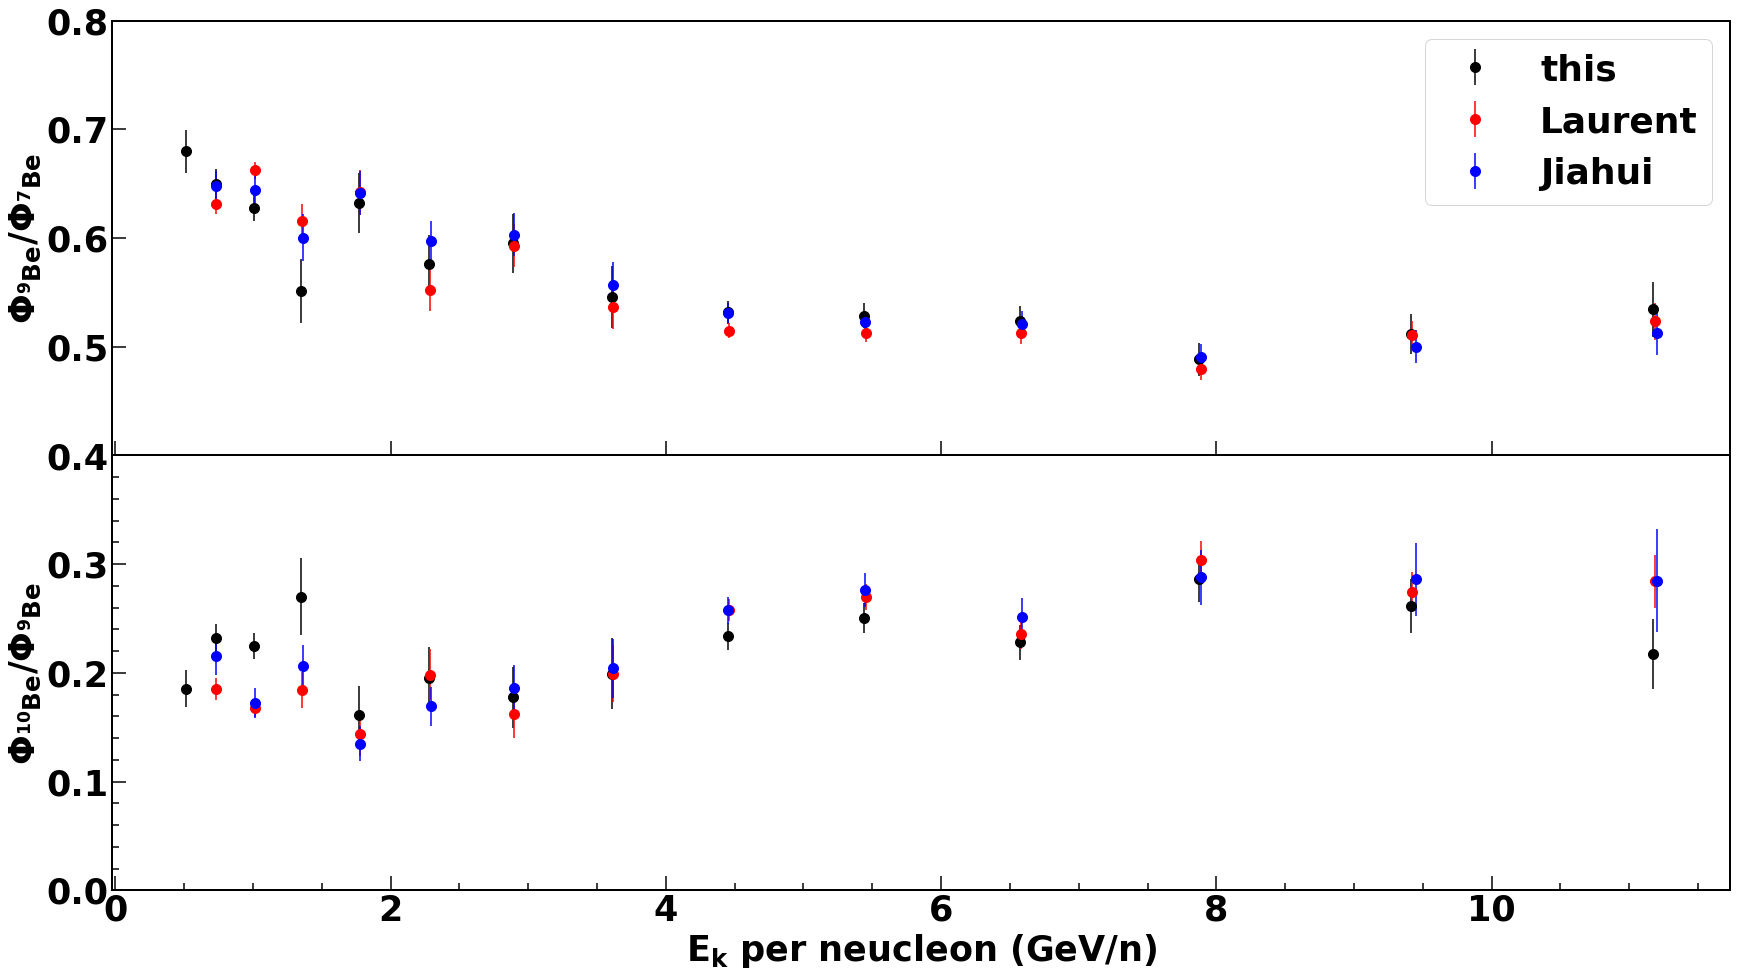

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(29, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 
ax2.set_ylabel(r"$\mathrm{\Phi_{^{10}Be}/\Phi_{^{9}Be}}$", fontsize=35) 
plot_graph(fig, ax2, graph_flux_ratio_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
#plot_graph(fig, ax2, graph_fluxratio_fixshape_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax2.set_ylim([0.0, 0.58])                                                                                                                             

#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
 
ax1.set_ylabel(r"$\mathrm{\Phi_{^{9}Be}/\Phi_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
plot_graph(fig, ax1, graph_flux_ratio_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20, label='this')
ax1.set_ylim([0.1, 1.0])                                                                                                                              
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
#plot_graph(fig, ax2, graph_flux_ratio_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
#plot_graph(fig, ax1, graph_flux_ratio_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20, label='this')


#file_path = "/home/manbing/Documents/lithiumanalysis/Plots_SPS_manbing/Jiahui_ICRC2023_results/ratio_Be10Be9.txt"
#file_path2 = "/home/manbing/Documents/lithiumanalysis/Plots_SPS_manbing/Jiahui_ICRC2023_results/ratio_Be9Be7.txt"
file_path7 = "/home/manbing/Documents/Data/jiahui/laurent/fluxes/7Be_21_Be7.txt"
file_path9 = "/home/manbing/Documents/Data/jiahui/laurent/fluxes/9Be_21_Be7.txt"
file_path10 = "/home/manbing/Documents/Data/jiahui/laurent/fluxes/10Be_21_Be7.txt"
# Load the data from the text file
data = np.loadtxt(file_path7)
data2 = np.loadtxt(file_path9)
data3 = np.loadtxt(file_path10)
# Split the data into separate arrays for each column
column71 = data[:, 0]
column72 = data[:, 1]
column73 = data[:, 2]
column74 = data[:, 3]
xv = (column71 + column72)/2

column93 = data2[:, 2]
column94 = data2[:, 3]
column03 = data3[:, 2]
column04 = data3[:, 3]

graph_laurent_fluxbe7 = MGraph(xv, column73, column74)
graph_laurent_fluxbe9 = MGraph(xv, column93, column94)
graph_laurent_fluxbe10 = MGraph(xv, column03, column04)
graph_laurent_ratiobe9 = graph_laurent_fluxbe9/graph_laurent_fluxbe7
graph_laurent_ratiobe10 = graph_laurent_fluxbe10/graph_laurent_fluxbe9

plot_graph(fig, ax2, graph_laurent_ratiobe10, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Laurent')
plot_graph(fig, ax1, graph_laurent_ratiobe9, color='red', style="EP", xlog=False, ylog=False, markersize=20, label='Laurent')
# Print the arrays


#print(graph_laurent_ratiobe10)
file_jh_be10 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be10Be9.txt'
file_jh_be9 = '/home/manbing/Documents/Data/jiahui/isotope_fluxes/20230526/ratio_Be9Be7.txt'
#file_jh_be9 = '/home/manbing/Documents/lithiumanalysis/Plots_SPS_manbing/Jiahui_ICRC2023_results/ratio_Be9Be7.txt'
df_jhbe10 = np.loadtxt(file_jh_be10)
df_jhbe9 = np.loadtxt(file_jh_be9)
c1_jh = df_jhbe10[:, 0]
c2_jh = df_jhbe10[:, 1]
c3_jh = df_jhbe10[:, 2]
c4_jh = df_jhbe10[:, 3]
xv_jh = (c1_jh + c2_jh)/2

c93_jh = df_jhbe9[:, 2]
c94_jh = df_jhbe9[:, 3]
graph_jiahui_ratiobe10 = MGraph(xv_jh, c3_jh, c4_jh)
graph_jiahui_ratiobe9 = MGraph(xv_jh, c93_jh, c94_jh)
ax1.set_ylim(0.4, 0.8)
ax2.set_ylim([0.0, 0.4])
print(graph_jiahui_ratiobe9)
plot_graph(fig, ax2, graph_jiahui_ratiobe10, color='blue', style="EP", xlog=False, ylog=False, markersize=20, label='Jiahui')
plot_graph(fig, ax1, graph_jiahui_ratiobe9, color='blue', style="EP", xlog=False, ylog=False, markersize=20, label='Jiahui')
ax1.legend()
savefig_tofile(fig, filepath, 'be_fluxratio_v23', 1)


In [28]:
graph_total_effcor = dict()
spline_total_effcor = dict()
with np.load(os.path.join(datadir,  "graph_total_effcor.npz")) as file_effcor: 
     for key, dec_alias in detectors_alias.items():  
            graph_total_effcor[key] = MGraph.from_file(file_effcor, f"graph_total_effcor_{dec_alias}") 
            #spline_total_effcor[key] = get_spline_from_graph(graph_total_effcor[key])   
            

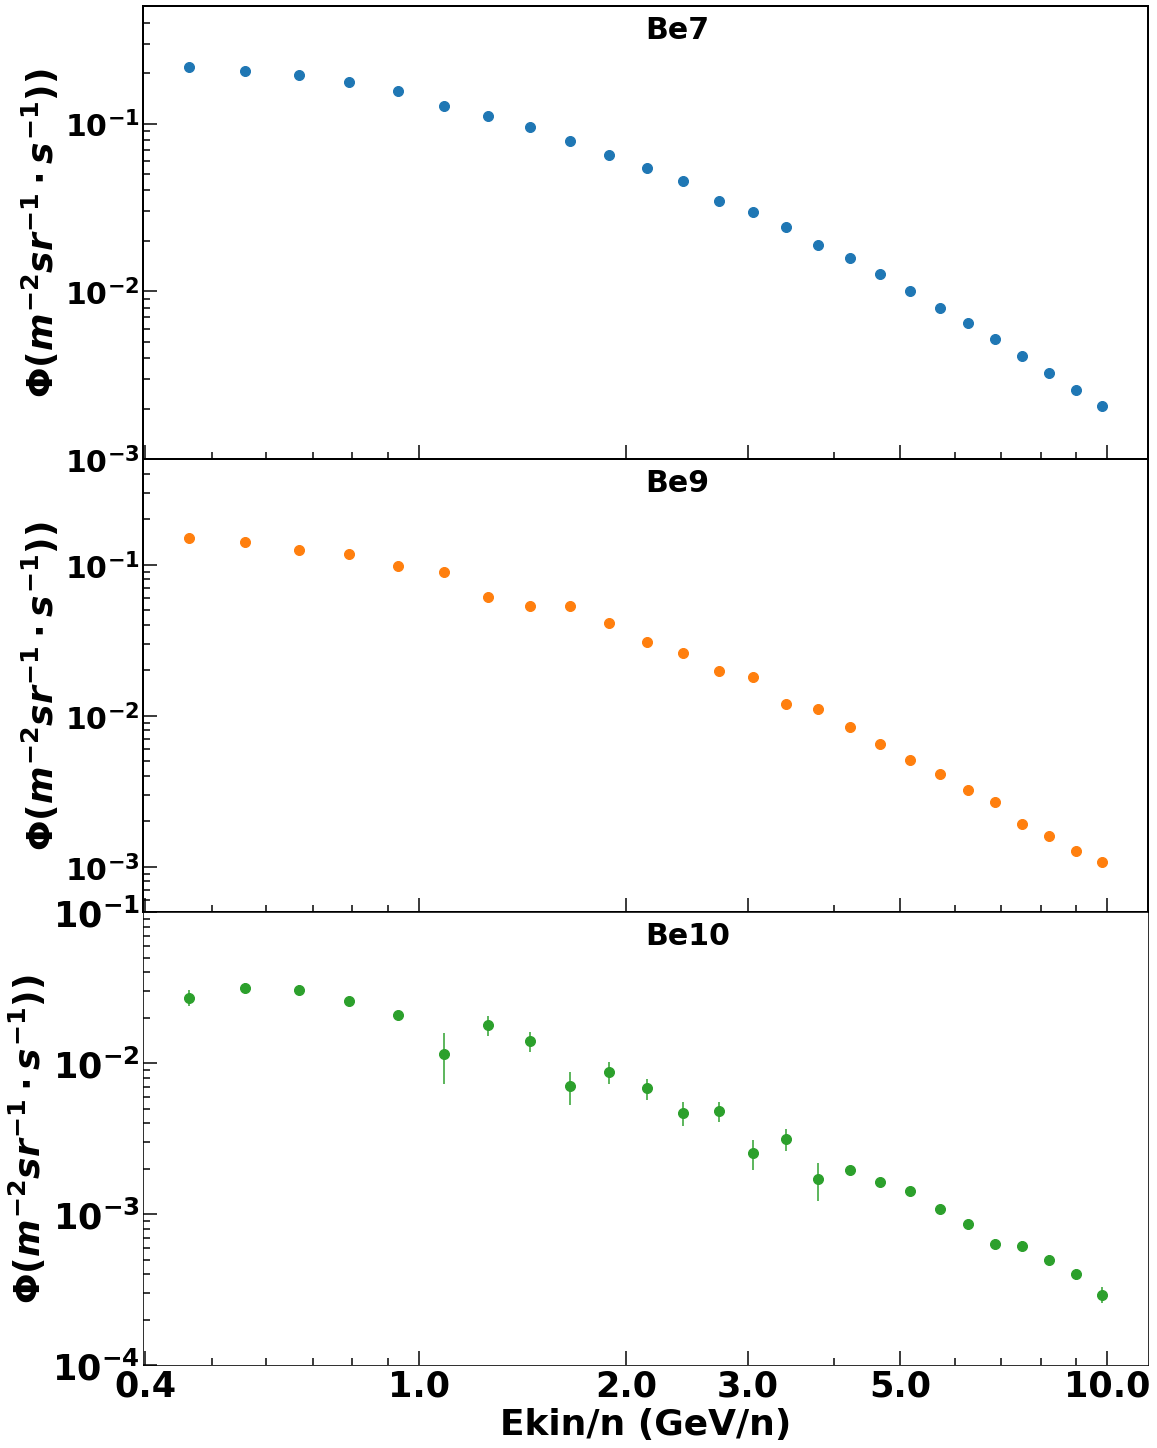

In [137]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc/Be_Isoflux.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc'
graph_flux = dict()
isoylim={'Be7': [0.001, 0.5], 'Be9':[0.0005, 0.5], 'Be10':[0.0001, 0.1]}
for iso in ISOTOPES['Be']:
    graph_flux[iso] = MGraph.from_file(data, f'graph_flux_{iso}')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(18, 25))
ax = [ax1, ax2, ax3]
for i, iso in enumerate(ISOTOPES['Be']):
    ax[i].text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
    ax[i].set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$")   
    plot_graph(fig, ax[i], graph_flux[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20)
    ax[i].set_ylim(isoylim[iso])    


ax3.set_xlabel("Ekin/n (GeV/n)")     
ax3.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax1.sharex(ax3)   
ax2.sharex(ax3)

ax1.get_xticklabels()[0].set_visible(False)   
ax2.get_xticklabels()[0].set_visible(False) 
set_plot_defaultstyle(ax1)                                                                                                                                                                                 
set_plot_defaultstyle(ax2)   
plt.subplots_adjust(hspace=.0)
savefig_tofile(fig, plotdir, 'be_isoflux', 1)




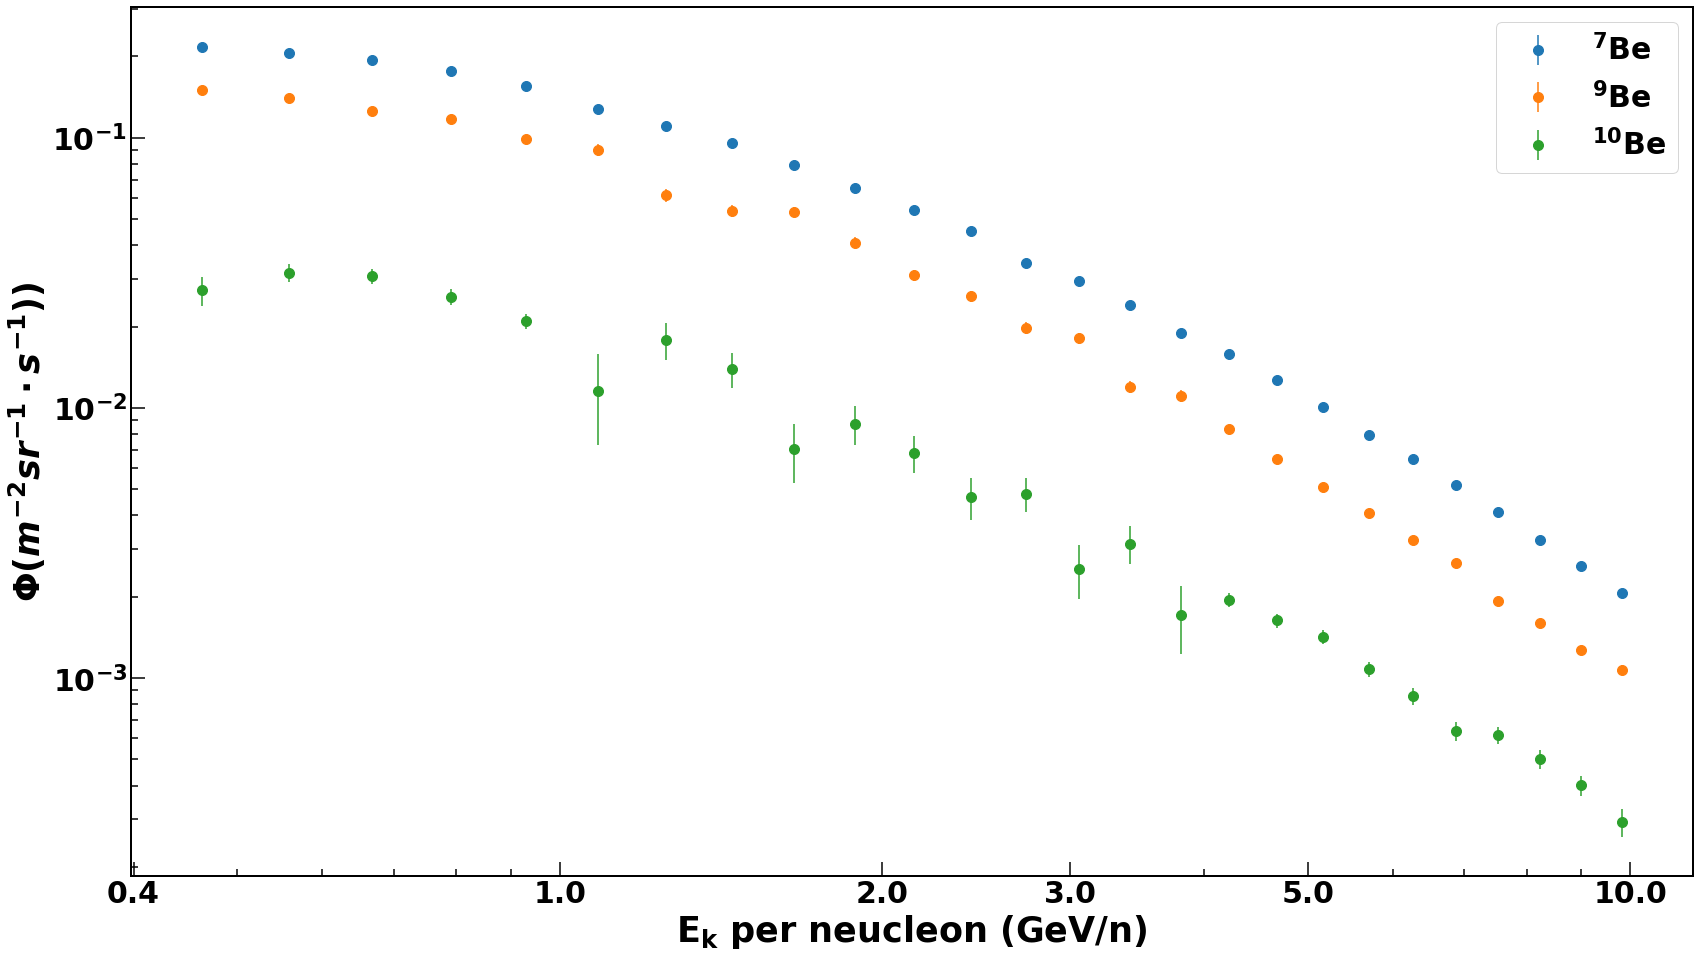

In [138]:
fig, ax1 = plt.subplots(figsize=(28, 16))
for iso in ISOTOPES['Be']:
    plot_graph(fig, ax1, graph_flux[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=True, markersize=20, label=f"{ISO_LABELS[iso]}")
    
ax1.set_ylabel(r"$\mathrm{\Phi} (m^{-2} sr^{-1} \cdot s^{-1})) }$", fontsize=35) 
ax1.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)     
ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())  
set_plot_defaultstyle(ax1)   
ax1.legend()
savefig_tofile(fig, plotdir, 'be_isoflux_2', 1)


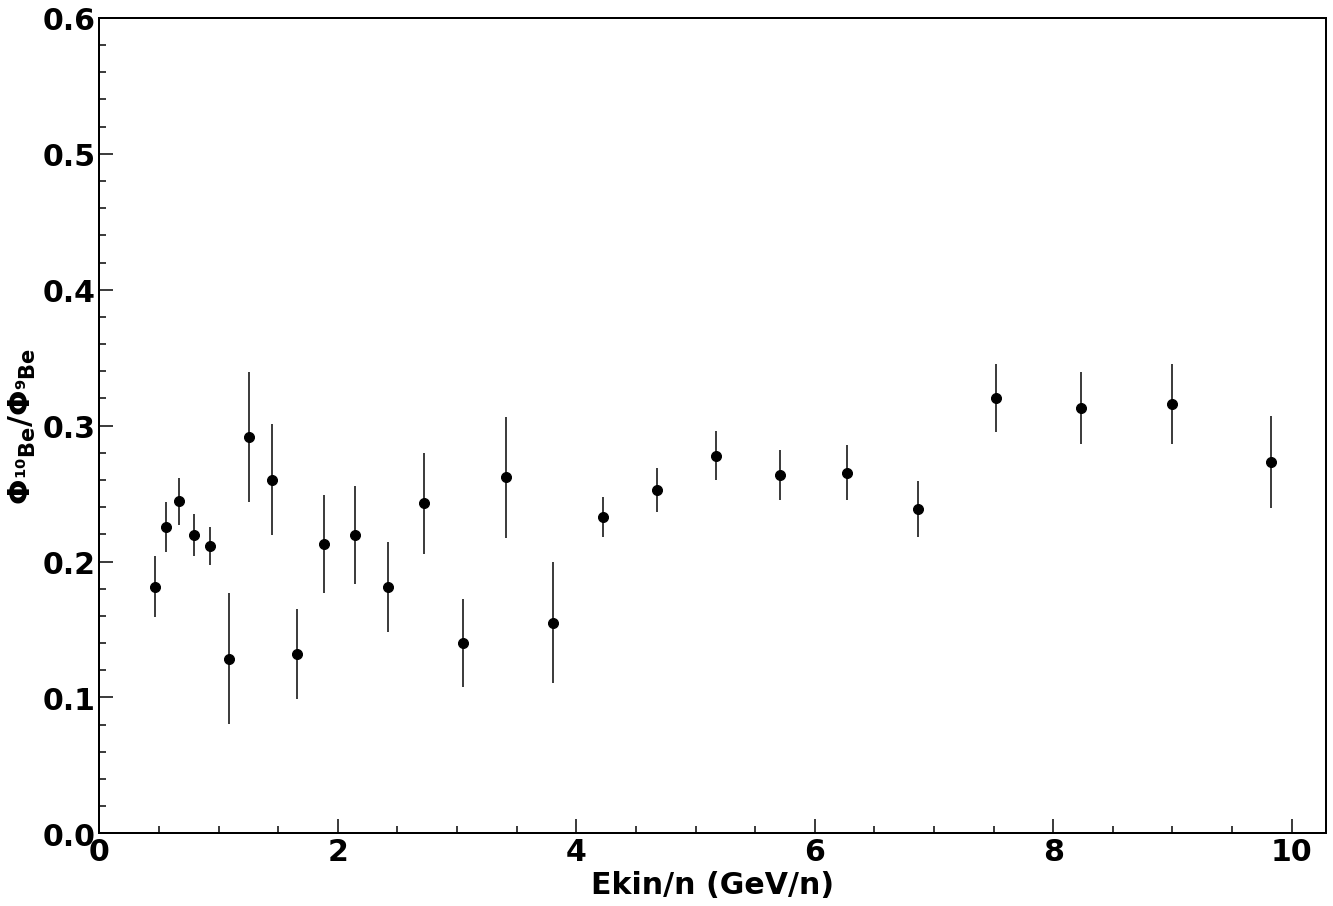

In [139]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc/Be_Isoflux.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc'
graph_flux_ratio_10to9 = dict()
graph_flux_ratio_10to9 = MGraph.from_file(data, f'graph_flux_ratio_10to9')
    
fig, ax1 = plt.subplots(figsize=(22, 15))
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 
ax1.set_ylabel(r"$\mathrm{\Phi_{^{10}Be}/\Phi_{^{9}Be}}$") 
plot_graph(fig, ax1, graph_flux_ratio_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax1.set_ylim([0.0, 0.6])                                                                                                                             
ax1.set_xlabel("Ekin/n (GeV/n)")     
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
set_plot_defaultstyle(ax1)                                                                                                                                                                                  
savefig_tofile(fig, plotdir, 'be_fluxratio_10to9', 1)

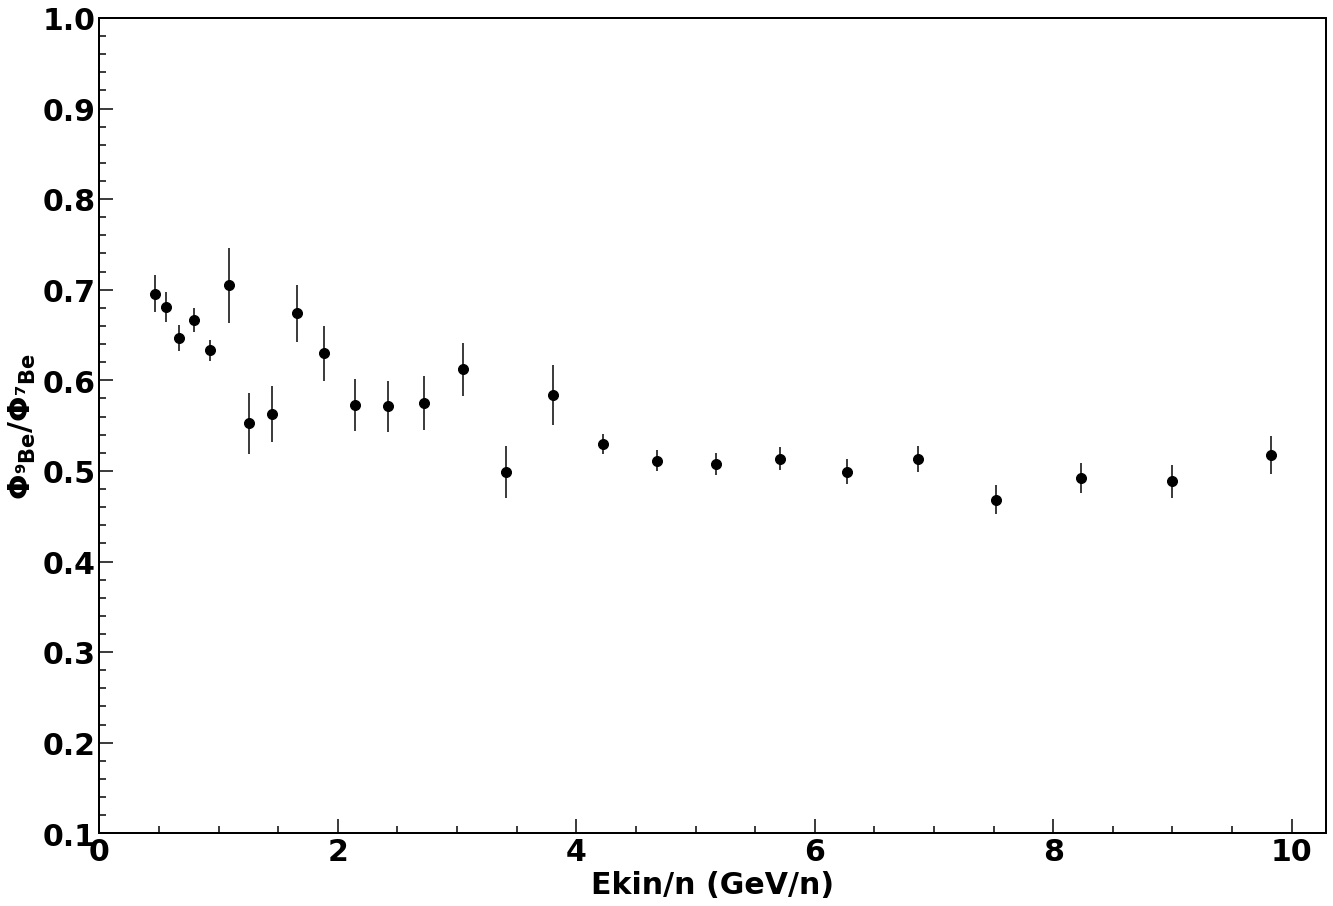

In [140]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc/Be_Isoflux.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc'
graph_flux_ratio_9to7 = dict()
graph_flux_ratio_9to7 = MGraph.from_file(data, f'graph_flux_ratio_9to7')
    
fig, ax1 = plt.subplots(figsize=(22, 15))
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
ax1.set_ylabel(r"$\mathrm{\Phi_{^{9}Be}/\Phi_{^{7}Be}}$")   
plot_graph(fig, ax1, graph_flux_ratio_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax1.set_ylim([0.1, 1.0])                                                                                                                             
ax1.set_xlabel("Ekin/n (GeV/n)")     
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
set_plot_defaultstyle(ax1)                                                                                                                                                                                  
savefig_tofile(fig, plotdir, 'be_fluxratio_9to7', 1)

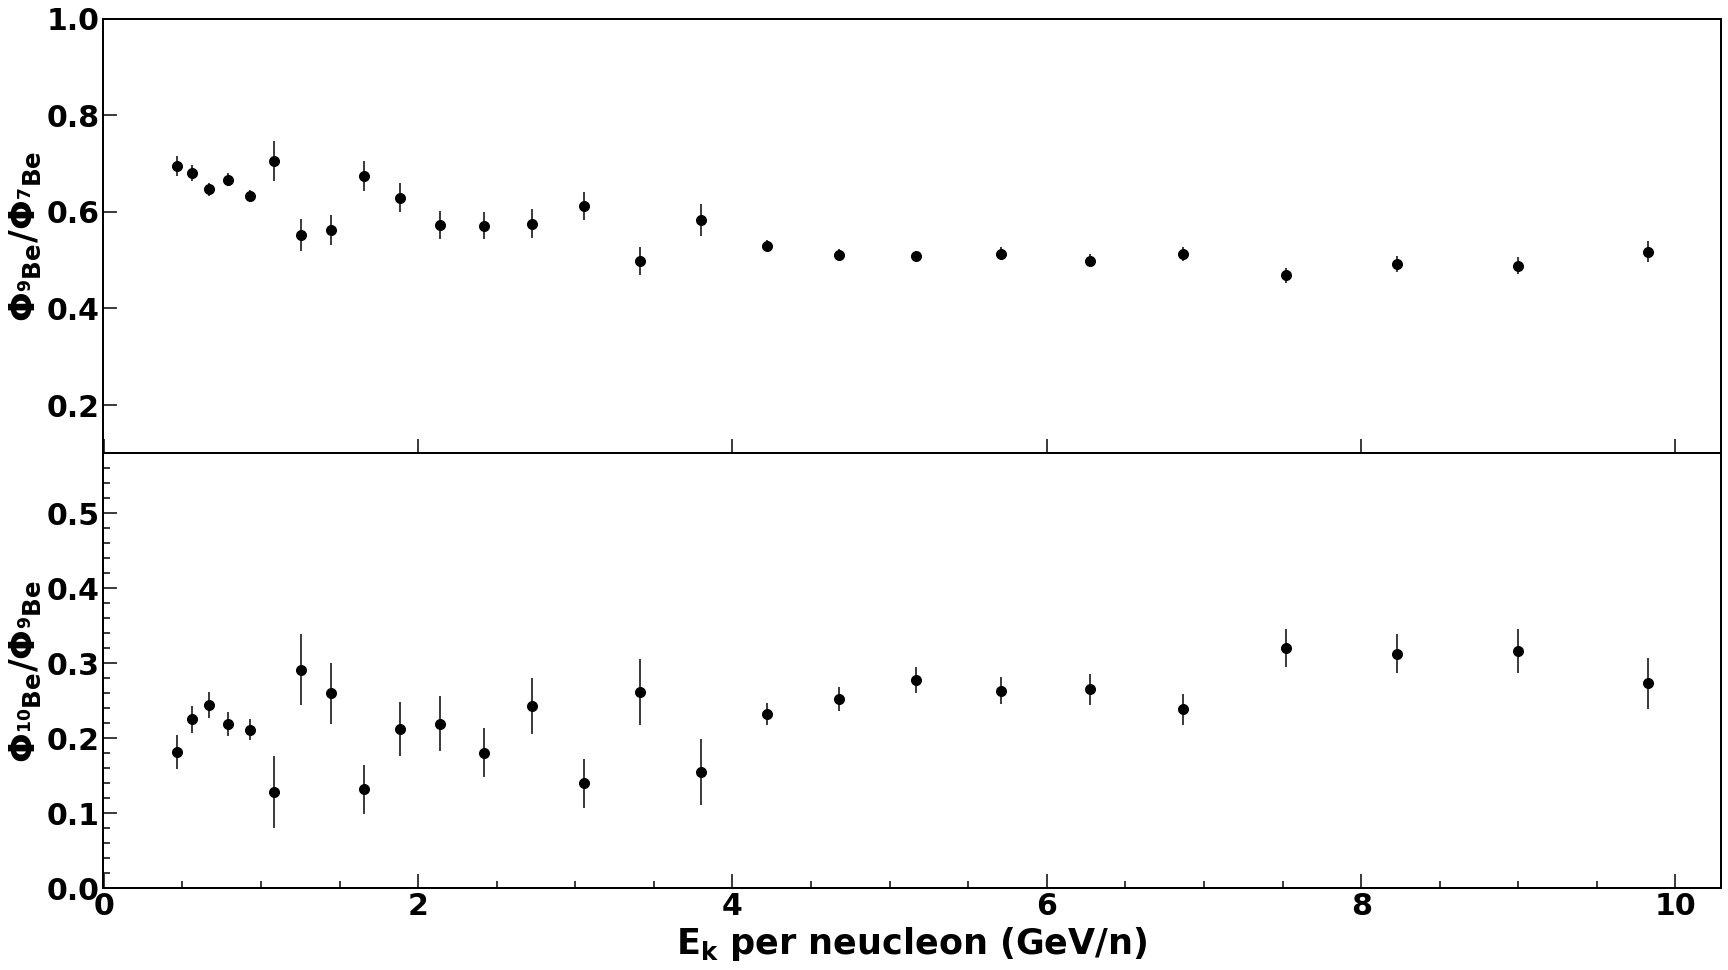

In [141]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(29, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 
ax2.set_ylabel(r"$\mathrm{\Phi_{^{10}Be}/\Phi_{^{9}Be}}$", fontsize=35) 
plot_graph(fig, ax2, graph_flux_ratio_10to9, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax2.set_ylim([0.0, 0.58])                                                                                                                             

#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
 
ax1.set_ylabel(r"$\mathrm{\Phi_{^{9}Be}/\Phi_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
plot_graph(fig, ax1, graph_flux_ratio_9to7, color='black', style="EP", xlog=False, ylog=False, markersize=20)
ax1.set_ylim([0.1, 1.0])                                                                                                                              
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
savefig_tofile(fig, plotdir, 'be_fluxratio', 1)

plot unfolding factor

In [142]:
from tools.binnings_collection import fbinning_energy2, get_bin_center
filename = '/home/manbing/Documents/Data/data_unfold/dfile/graph_unfoldfactor.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc'
graph_unfoldfactor_mc = dict()
graph_unfoldfactor_iss= dict()
detectors = ['Tof', 'NaF', 'Agl']

for dec in detectors:
    graph_unfoldfactor_mc[dec] = MGraph.from_file(data, f'graph_unfold_{dec}_mc')
    graph_unfoldfactor_iss[dec] = MGraph.from_file(data, f'graph_unfold_{dec}_iss')
graph_unfoldfactor_mc['Tof'] = slice_graph_by_value(graph_unfoldfactor_mc['Tof'], [0.4, 1.1])
graph_unfoldfactor_mc['Agl'] = slice_graph_by_value(graph_unfoldfactor_mc['Agl'], [3.0, 12.0])
graph_unfoldfactor_mc['NaF'] = slice_graph_by_value(graph_unfoldfactor_mc['NaF'], [1.0, 4.5])
graph_unfoldfactor_iss['NaF'] = slice_graph_by_value(graph_unfoldfactor_iss['NaF'], [1.0, 4.5])
graph_unfoldfactor_iss['Agl'] = slice_graph_by_value(graph_unfoldfactor_iss['Agl'], [3.0, 12.0])
fig, ax1 = plt.subplots(figsize=(22, 15))
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
ax1.set_ylabel(r"unfolding factor") 
for dec in detectors:
    #plot_graph(fig, ax1, graph_unfoldfactor_iss[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20)
    plot_graph(fig, ax1, graph_unfoldfactor_mc[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=True, ylog=False, markersize=20, label=f'MC {dec}')

ax1.set_ylim([0.8, 1.3])                                                                                                                             
ax1.set_xlabel("Ekin/n (GeV/n)")     
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
set_plot_defaultstyle(ax1)  
unfoldfactor_jiahui = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
                                1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
                                1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
                                1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
                                1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
                                1.02470803, 1.02454688, 1.02561412, 1.02929802])
unfoldfactor_xekin_jiahui = get_bin_center(fbinning_energy2())
graph_jiahui_unfold = MGraph(unfoldfactor_xekin_jiahui, unfoldfactor_jiahui, np.zeros_like(unfoldfactor_jiahui))
plot_graph(fig, ax1, graph_jiahui_unfold, color='black', style="EP", xlog=False, ylog=False, markersize=20, label=f'Jiahui')
ax1.legend()

savefig_tofile(fig, plotdir, 'unfold_factor', 1)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [ ]:
from tools.binnings_collection import fbinning_energy, get_bin_center, fbinning_energy2
filename = '/home/manbing/Documents/Data/data_unfold/dfile/graph_unfoldfactor.npz'
data = np.load(f'{filename}')
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/isotopesflux/thismc'
graph_unfoldfactor_mc = dict()
graph_unfoldfactor_iss= dict()
detectors = ['Tof', 'NaF', 'Agl']

for dec in detectors:
    graph_unfoldfactor_mc[dec] = MGraph.from_file(data, f'graph_unfold_{dec}_mc')
    graph_unfoldfactor_iss[dec] = MGraph.from_file(data, f'graph_unfold_{dec}_iss')
graph_unfoldfactor_mc['Tof'] = slice_graph_by_value(graph_unfoldfactor_mc['Tof'], [0.4, 1.1])
graph_unfoldfactor_mc['Agl'] = slice_graph_by_value(graph_unfoldfactor_mc['Agl'], [3.0, 12.0])
graph_unfoldfactor_mc['NaF'] = slice_graph_by_value(graph_unfoldfactor_mc['NaF'], [1.0, 4.5])
graph_unfoldfactor_iss['NaF'] = slice_graph_by_value(graph_unfoldfactor_iss['NaF'], [1.0, 4.5])
graph_unfoldfactor_iss['Agl'] = slice_graph_by_value(graph_unfoldfactor_iss['Agl'], [3.0, 12.0])
graph_unfoldfactor_iss['Tof'] = slice_graph_by_value(graph_unfoldfactor_iss['Tof'], [0.3, 1.1])
fig, ax1 = plt.subplots(figsize=(22, 15))
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold")
ax1.set_ylabel(r"unfolding factor") 
for dec in detectors:
    plot_graph(fig, ax1, graph_unfoldfactor_iss[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label=f'ISS {dec}')
    

ax1.set_ylim([0.8, 1.3])                                                                                                                             
ax1.set_xlabel("Ekin/n (GeV/n)")     
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
set_plot_defaultstyle(ax1)    
ax1.legend()

#jiahui unfolding factor

unfoldfactor_jiahui = np.array([1.10415405, 1.11743185, 1.11979867, 1.11092794, 1.10511991,
                                1.09820484, 1.09441089, 1.08260727, 1.0732978 , 1.07024319,
                                1.06461786, 1.05648085, 1.04974455, 1.04560352, 1.04344912,
                                1.04213655, 1.03396483, 1.03728443, 1.03752972, 1.03607738,
                                1.03368557, 1.03075394, 1.02806917, 1.02610837, 1.0254245 ,
                                1.02470803, 1.02454688, 1.02561412, 1.02929802])
unfoldfactor_xekin_jiahui = get_bin_center(fbinning_energy2())
print(fbinning_energy2())

graph_jiahui_unfold = MGraph(unfoldfactor_xekin_jiahui, unfoldfactor_jiahui, np.zeros_like(unfoldfactor_jiahui))
print(graph_jiahui_unfold)
print(graph_unfoldfactor_iss['NaF'])
plot_graph(fig, ax1, graph_jiahui_unfold, color='black', style="EP", xlog=False, ylog=False, markersize=20, label=f'Jiahui')
savefig_tofile(fig, plotdir, 'unfold_factor', 1)